In [2]:
%pip install -U pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# 讀取raw.csv
df = pd.read_csv('data/raw.csv')

# 日期轉成時間格式
df['Date'] = pd.to_datetime(df['Date'])

# 新增年份欄位
df['Year'] = df['Date'].dt.year

# 檢查前五筆資料
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume,Year
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100600,469033600,1980
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095352,175884800,1980
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088353,105728000,1980
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090540,86441600,1980
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.093165,73449600,1980


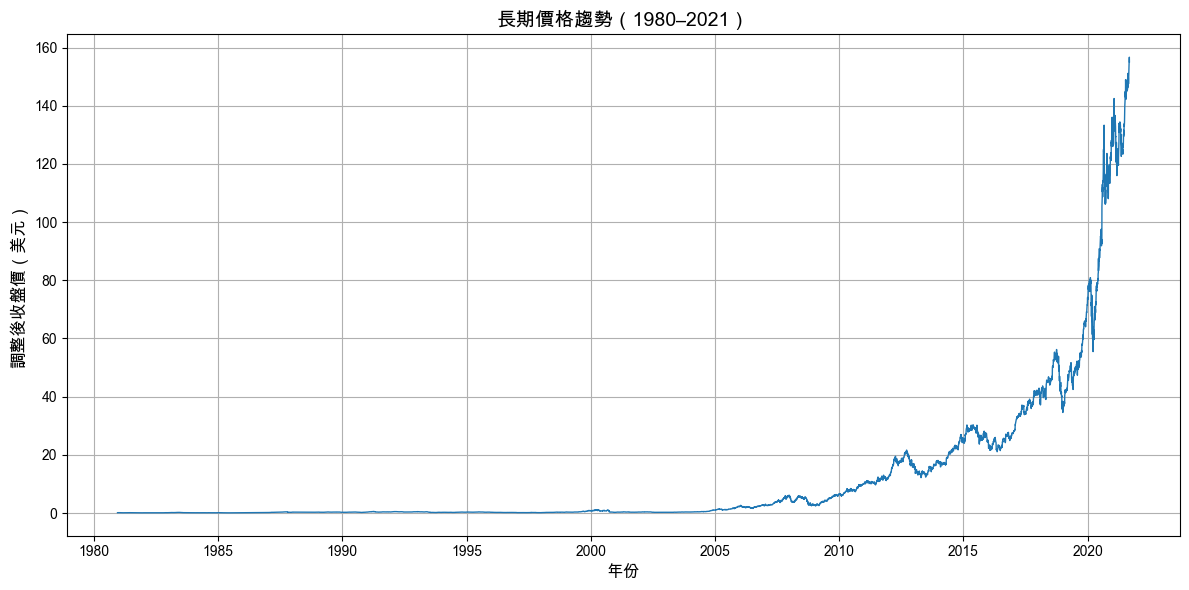

In [4]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# 設定中文字體（macOS）
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

def y_fmt(y, pos):
    if y >= 1_000_000_000:
        return f'{y/1_000_000_000:.1f}B'
    elif y >= 1_000_000:
        return f'{y/1_000_000:.1f}M'
    elif y >= 1_000:
        return f'{y/1_000:.1f}K'
    else:
        return f'{y:.0f}'

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(df['Date'], df['Adj Close'], linewidth=1)

ax.set_title('長期價格趨勢（1980–2021）', fontsize=14)
ax.set_xlabel('年份', fontsize=12)
ax.set_ylabel('調整後收盤價（美元）', fontsize=12)
ax.yaxis.set_major_formatter(FuncFormatter(y_fmt))  # 套用單位格式

ax.grid(True)
plt.tight_layout()
plt.show()

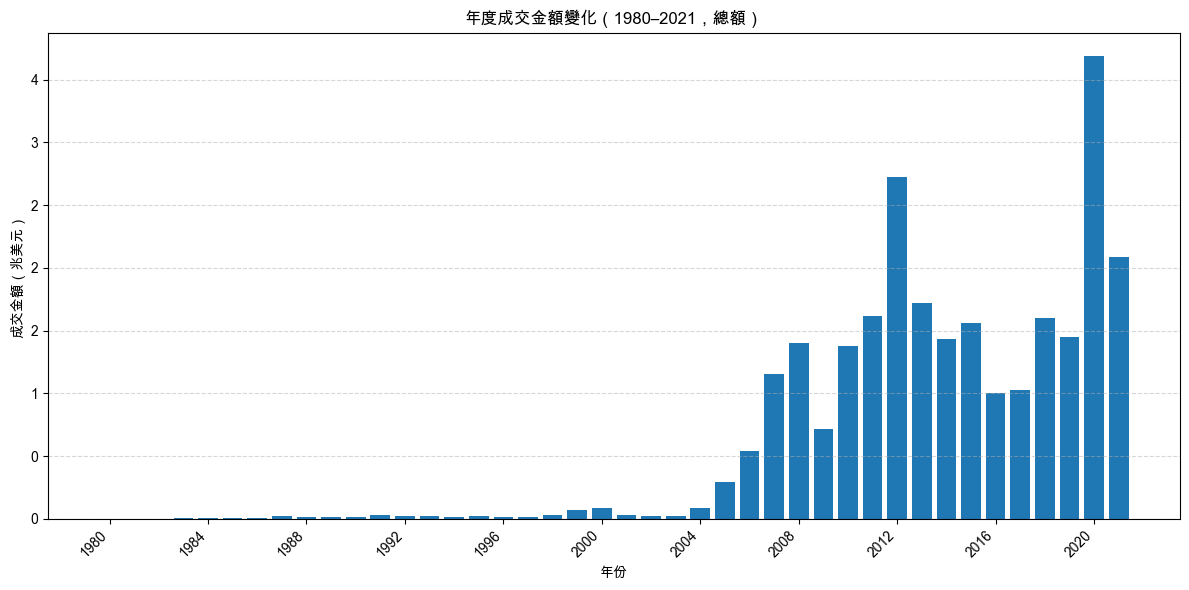

資料期間： 1980-12-12 → 2021-09-08
年份筆數：
 Year
1980     13
1981    253
1982    253
1983    253
1984    253
Name: count, dtype: int64
年度成交金額前 5 高：
 Year
2020    3.688 兆美元
2012    2.721 兆美元
2021    2.087 兆美元
2013    1.716 兆美元
2011    1.618 兆美元
Name: DollarValue, dtype: object


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date']).sort_values('Date')

for col in ['Open','High','Low','Close','Adj Close','Volume']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna(subset=['Close','Volume'])  # 異常列丟掉

# 加 Year 欄
df['Year'] = df['Date'].dt.year


df['DollarValue'] = df['Close'] * df['Volume']
annual_turnover = df.groupby('Year', as_index=True)['DollarValue'].sum()

#   動態單位
def choose_scale_for_usd(xmax):
    if xmax >= 1e12:
        return 1e-12, '兆美元'
    elif xmax >= 1e9:
        return 1e-9, '十億美元'
    elif xmax >= 1e6:
        return 1e-6, '百萬美元'
    return 1.0, '美元'

scale, unit = choose_scale_for_usd(float(annual_turnover.max()))
plot_values = annual_turnover * scale

#  繪圖
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(annual_turnover.index, plot_values.values, width=0.8)

ax.set_title('年度成交金額變化（1980–2021，總額）')
ax.set_xlabel('年份'); ax.set_ylabel(f'成交金額（{unit}）')

ax.xaxis.set_major_locator(MaxNLocator(nbins=14, integer=True))
plt.xticks(rotation=45, ha='right')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:,.0f}'))
ax.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout(); plt.show()

# 快速健檢
print('資料期間：', df['Date'].min().date(), '→', df['Date'].max().date())
print('年份筆數：\n', df['Year'].value_counts().sort_index().head())
print('年度成交金額前 5 高：\n', (annual_turnover.sort_values(ascending=False).head()/1e12).round(3).astype(str)+' 兆美元')



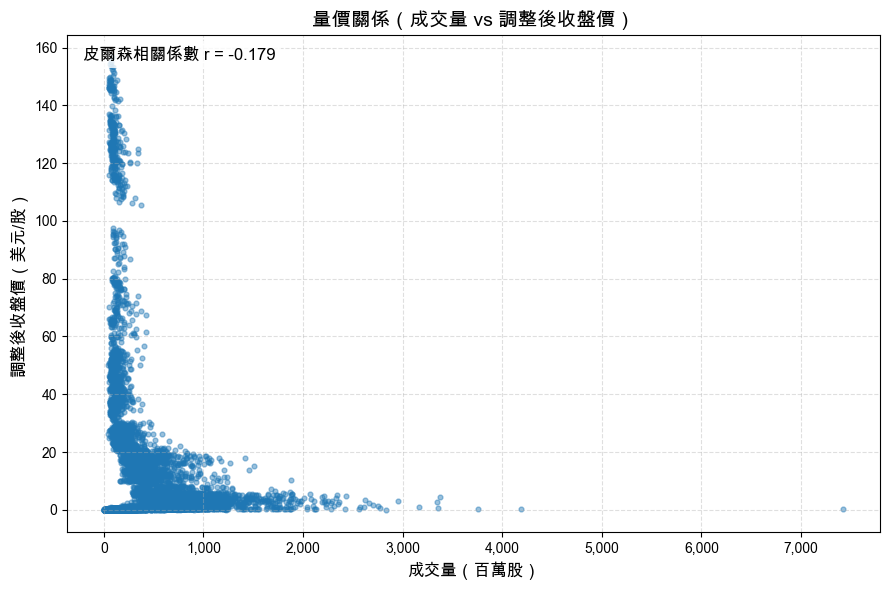

In [6]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 把成交量換成「百萬股」
df['Volume_M'] = df['Volume'] / 1_000_000

fig, ax = plt.subplots(figsize=(9, 6))

# 用百萬股當 x 軸
ax.scatter(df['Volume_M'], df['Adj Close'], alpha=0.45, s=12)

ax.set_title('量價關係（成交量 vs 調整後收盤價）', fontsize=14)
ax.set_xlabel('成交量（百萬股）', fontsize=12)
ax.set_ylabel('調整後收盤價（美元/股）', fontsize=12)

ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:,.0f}'))

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))

ax.grid(True, linestyle='--', alpha=0.4)

# 相關係數用原本的 Volume
corr = df['Volume'].corr(df['Adj Close'])

ax.text(
    0.02, 0.95,
    f'皮爾森相關係數 r = {corr:.3f}',
    transform=ax.transAxes,
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none')
)

plt.tight_layout()
plt.show()

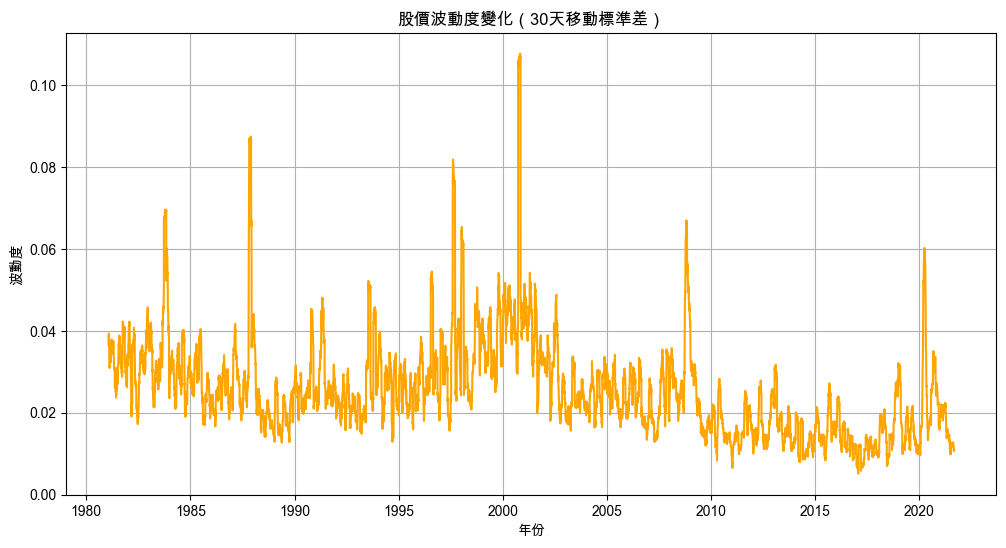

In [7]:
df['Return'] = df['Adj Close'].pct_change()
df['Volatility'] = df['Return'].rolling(30).std()  
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Volatility'], color='orange')
plt.title('股價波動度變化（30天移動標準差）')
plt.xlabel('年份'); plt.ylabel('波動度')
plt.grid(True); plt.show()

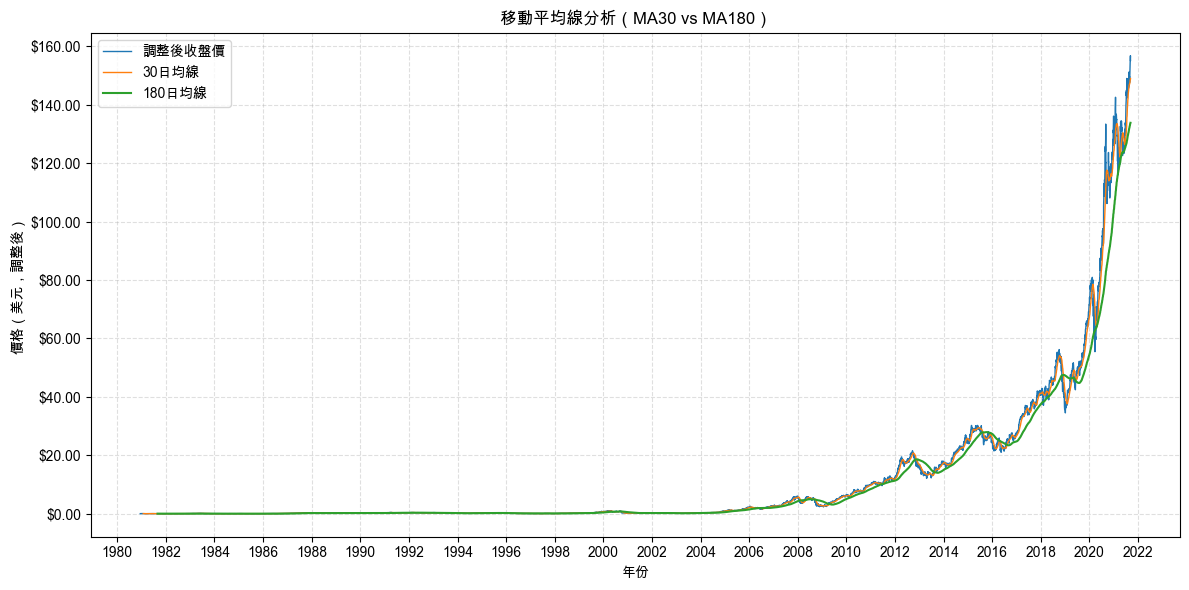

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

df['MA30']  = df['Adj Close'].rolling(30).mean()
df['MA180'] = df['Adj Close'].rolling(180).mean()

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(df['Date'], df['Adj Close'], label='調整後收盤價', linewidth=1)
ax.plot(df['Date'], df['MA30'],  label='30日均線', linewidth=1)
ax.plot(df['Date'], df['MA180'], label='180日均線', linewidth=1.5)

ax.set_title('移動平均線分析（MA30 vs MA180）')
ax.set_xlabel('年份')
ax.set_ylabel('價格（美元，調整後）')

ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'${y:,.2f}'))

ax.xaxis.set_major_locator(mdates.YearLocator(base=2))  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=0)

ax.legend()
ax.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()



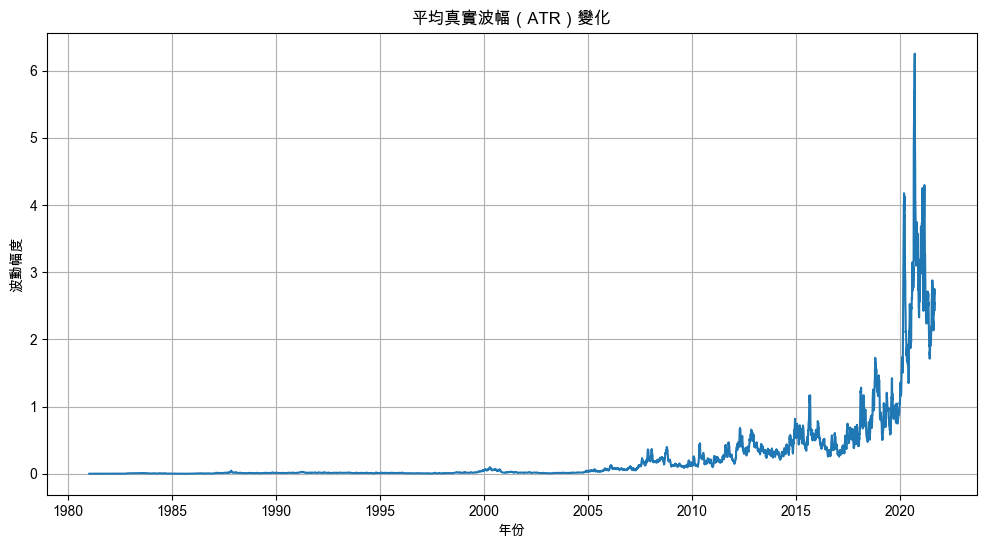

In [9]:
df['Range'] = df['High'] - df['Low']
df['ATR'] = df['Range'].rolling(14).mean()  
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['ATR'])
plt.title('平均真實波幅（ATR）變化')
plt.xlabel('年份'); plt.ylabel('波動幅度')
plt.grid(True); plt.show()


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 建立「絕對振幅」與「相對振幅(%)」
df['Range'] = df['High'] - df['Low']
df['RangePct'] = (df['Range'] / df['Open']) * 100

# 方便分組的年月/年欄位
df['Year'] = df['Date'].dt.year
df['YearMonth'] = df['Date'].dt.to_period('M').astype(str)  # e.g. '2007-06'


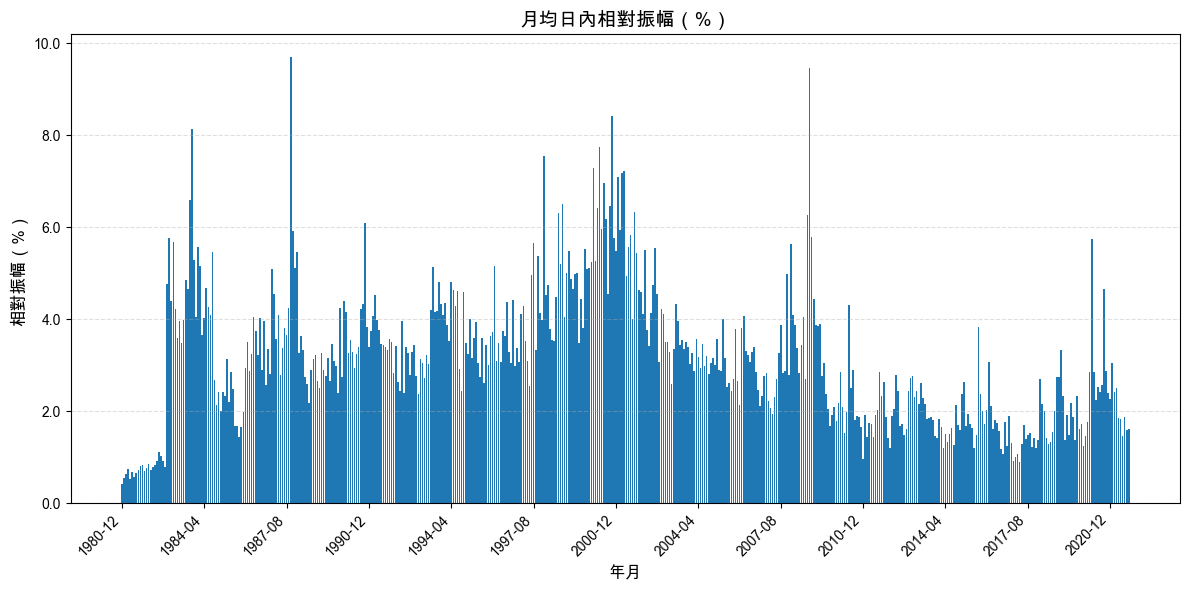

In [11]:
monthly = df.groupby('YearMonth')['RangePct'].mean().reset_index()

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(monthly['YearMonth'], monthly['RangePct'])

ax.set_title('月均日內相對振幅（%）', fontsize=14)
ax.set_xlabel('年月', fontsize=12)
ax.set_ylabel('相對振幅（%）', fontsize=12)

ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.1f}'))
ax.xaxis.set_major_locator(MaxNLocator(nbins=14))  
plt.xticks(rotation=45, ha='right')

ax.grid(True, axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


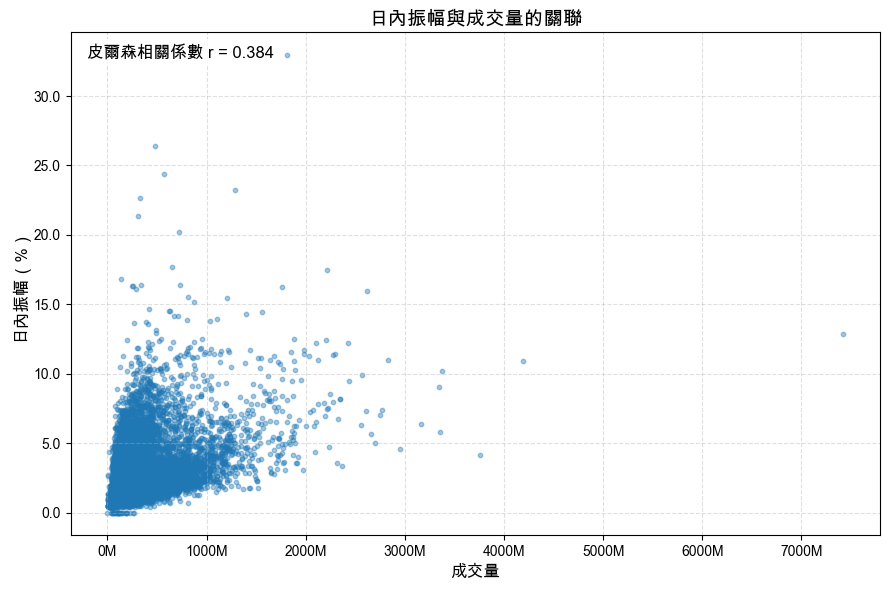

成交量與日內振幅比率的皮爾森相關係數：0.384


In [12]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# 建立日內振幅比率(%) 欄位
df['RangePct'] = (df['High'] - df['Low']) / df['Open'] * 100

# 計算成交量與振幅比率的皮爾森相關係數
corr = df['Volume'].corr(df['RangePct'])

# 中文字體設定（macOS 用 Arial Unicode MS；Windows 改為 Microsoft JhengHei）
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# --- 畫散點圖 ---
fig, ax = plt.subplots(figsize=(9,6))
ax.scatter(df['Volume'], df['RangePct'], alpha=0.4, s=10)

ax.set_title('日內振幅與成交量的關聯', fontsize=14)
ax.set_xlabel('成交量', fontsize=12)
ax.set_ylabel('日內振幅（%）', fontsize=12)

# 成交量以「百萬股」顯示
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1_000_000:.0f}M'))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.1f}'))

# 在圖上顯示相關係數
ax.text(0.02, 0.95,
        f'皮爾森相關係數 r = {corr:.3f}',
        transform=ax.transAxes,
        fontsize=12,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

ax.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

print(f'成交量與日內振幅比率的皮爾森相關係數：{corr:.3f}')


        Date  Year  Month  Decade
0 1980-12-12  1980     12    1980
1 1980-12-15  1980     12    1980
2 1980-12-16  1980     12    1980
3 1980-12-17  1980     12    1980
4 1980-12-18  1980     12    1980
    Decade  Month  Adj Close
0     1980      1   0.147278
1     1980      2   0.150969
2     1980      3   0.151309
3     1980      4   0.153387
4     1980      5   0.168914
5     1980      6   0.174224
6     1980      7   0.158265
7     1980      8   0.163296
8     1980      9   0.166651
9     1980     10   0.157154
10    1980     11   0.152556
11    1980     12   0.151325
12    1990      1   0.291491
13    1990      2   0.292818
14    1990      3   0.295851
15    1990      4   0.291279
16    1990      5   0.293897
17    1990      6   0.273590
18    1990      7   0.271854
19    1990      8   0.289429
20    1990      9   0.288305
21    1990     10   0.284427
22    1990     11   0.320109
23    1990     12   0.325746


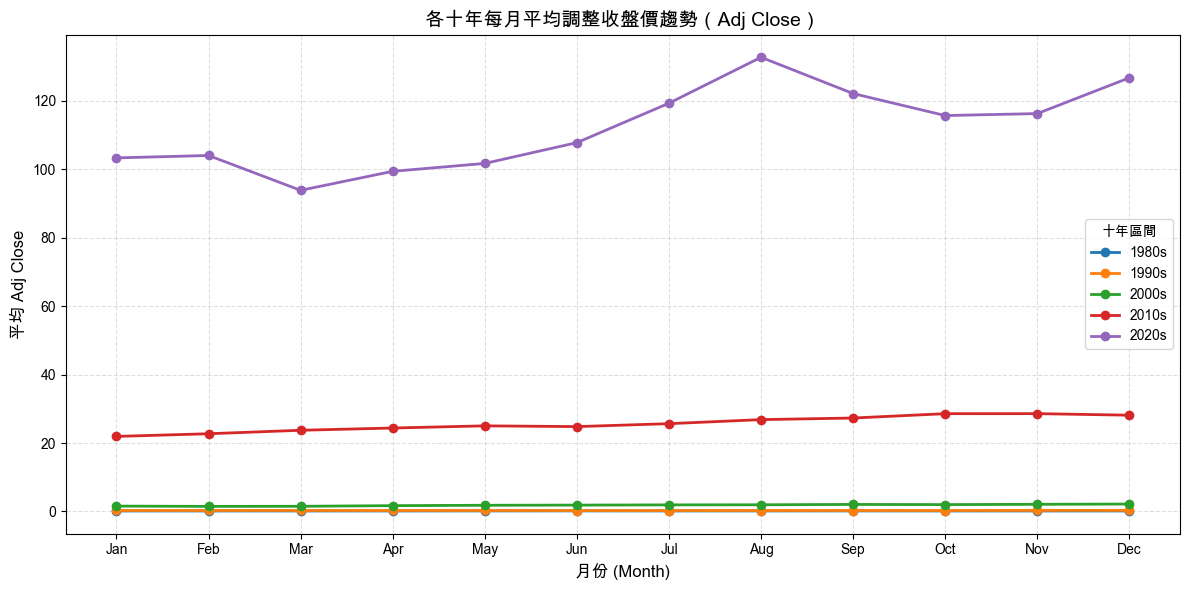

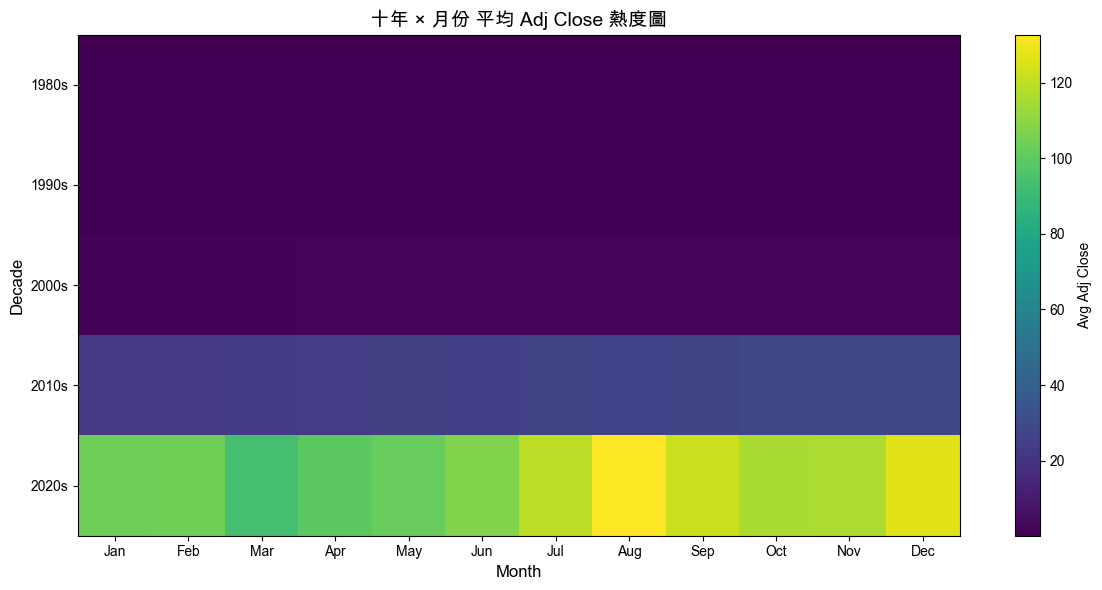

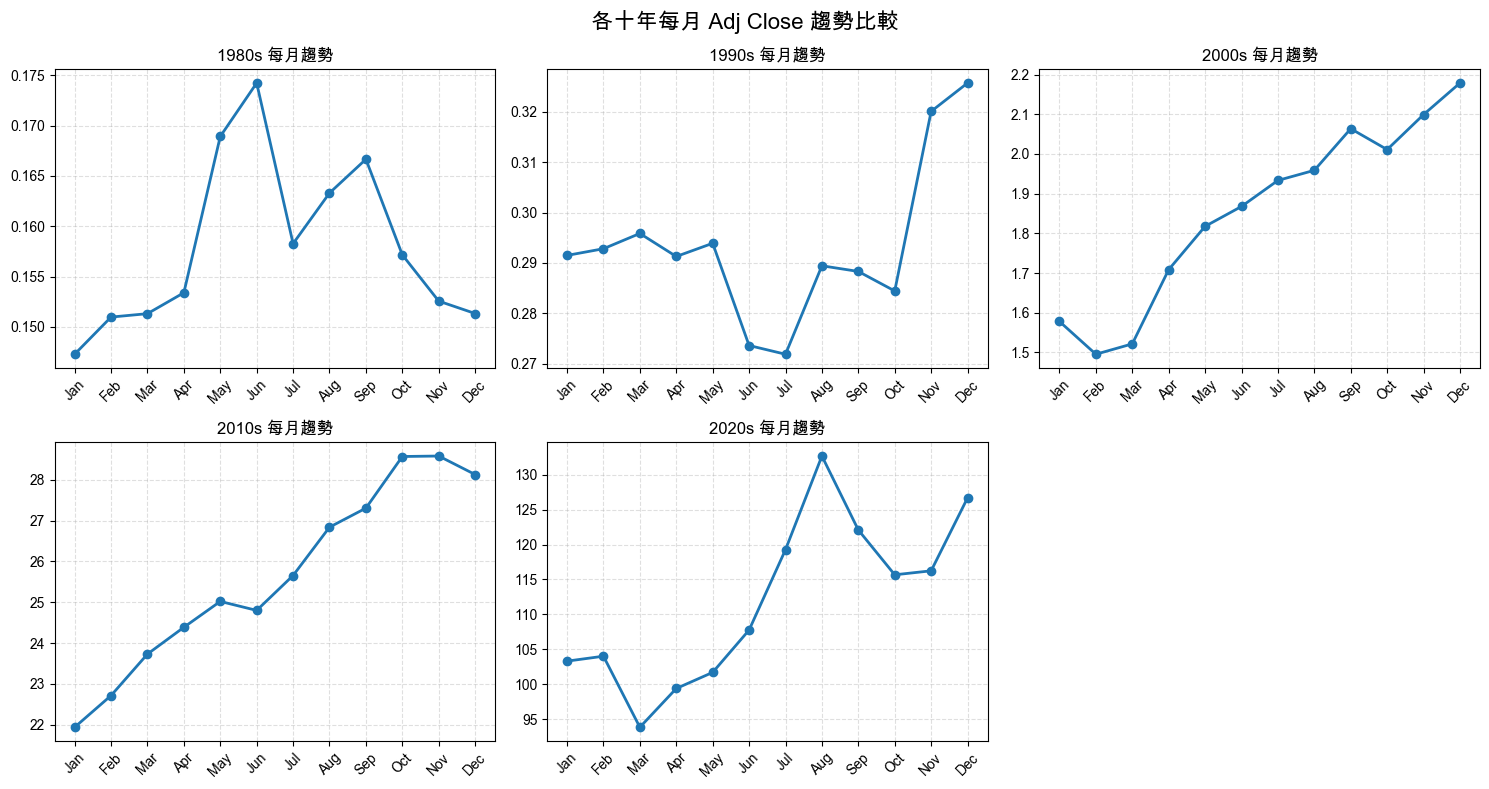

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 讀資料
df = pd.read_csv('data/raw.csv')
df['Date'] = pd.to_datetime(df['Date'])

# 2. 建新欄位：Year / Month / Decade
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month              # 1~12
df['Decade'] = (df['Year'] // 10) * 10         # 1980, 1990, 2000 ...

print(df[['Date','Year','Month','Decade']].head())

# 3. 十年 + 月 分組平均 (Adj Close)
df_m = (
    df.groupby(['Decade', 'Month'])['Adj Close']
      .mean()
      .reset_index()
      .sort_values(['Decade','Month'])
)

print(df_m.head(24))

# 4. 主折線圖：每條線一個十年，X=月份(1~12)
plt.figure(figsize=(12,6))

decades = sorted(df_m['Decade'].unique())
for decade in decades:
    temp = df_m[df_m['Decade'] == decade]
    plt.plot(temp['Month'], temp['Adj Close'], marker='o', linewidth=2, label=f'{decade}s')

plt.title('各十年每月平均調整收盤價趨勢（Adj Close）', fontsize=14)
plt.xlabel('月份 (Month)', fontsize=12)
plt.ylabel('平均 Adj Close', fontsize=12)

plt.xticks(range(1,13), 
           ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])

plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(title="十年區間")
plt.tight_layout()
plt.show()

# 5. 進階圖1：Heatmap 十年 × 月份
pivot_m = df_m.pivot(index='Decade', columns='Month', values='Adj Close')

plt.figure(figsize=(12,6))
plt.imshow(pivot_m, aspect='auto')

plt.title('十年 × 月份 平均 Adj Close 熱度圖', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Decade', fontsize=12)

plt.xticks(range(12), 
           ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])

plt.yticks(range(len(pivot_m.index)), [f'{d}s' for d in pivot_m.index])

plt.colorbar(label='Avg Adj Close')
plt.tight_layout()
plt.show()


# 6. 進階圖2：每十年一張「每月趨勢小圖」(subplots)
n = len(decades)
cols = 3
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
axes = axes.flatten()

for i, decade in enumerate(decades):
    temp = df_m[df_m['Decade'] == decade]
    axes[i].plot(temp['Month'], temp['Adj Close'], marker='o', linewidth=2)
    axes[i].set_title(f'{decade}s 每月趨勢', fontsize=12)
    axes[i].set_xticks(range(1,13))
    axes[i].set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], rotation=45)
    axes[i].grid(True, linestyle='--', alpha=0.4)

for j in range(i+1, len(axes)):
    axes[j].axis('off')

fig.suptitle('各十年每月 Adj Close 趨勢比較', fontsize=16)
plt.tight_layout()
plt.show()



資料期間： 2000-01-03 00:00:00 → 2009-12-31 00:00:00
           Date  Year  Month  Period2Y
4816 2000-01-03  2000      1      2000
4817 2000-01-04  2000      1      2000
4818 2000-01-05  2000      1      2000
4819 2000-01-06  2000      1      2000
4820 2000-01-07  2000      1      2000
    Period2Y  Month  Adj Close
0       2000      1   0.531295
1       2000      2   0.585535
2       2000      3   0.659065
3       2000      4   0.638403
4       2000      5   0.566814
5       2000      6   0.546416
6       2000      7   0.570627
7       2000      8   0.536316
8       2000      9   0.597588
9       2000     10   0.289965
10      2000     11   0.300479
11      2000     12   0.281072
12      2002      1   0.284278
13      2002      2   0.295008
14      2002      3   0.295987
15      2002      4   0.296355
16      2002      5   0.322234
17      2002      6   0.289013
18      2002      7   0.280573
19      2002      8   0.273445
20      2002      9   0.282603
21      2002     10   0.288706
22   

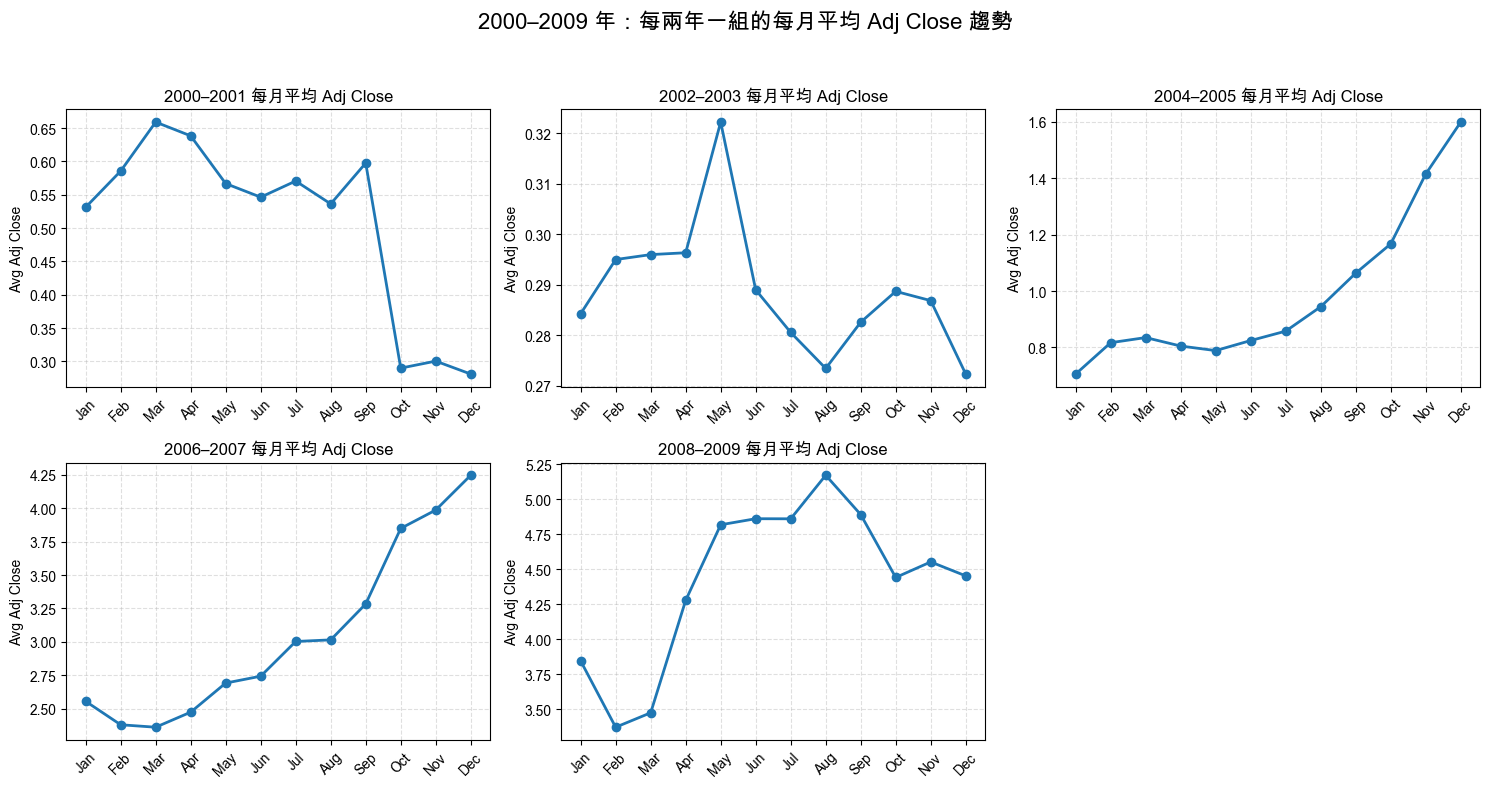

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["font.sans-serif"] = ["Microsoft JhengHei", "Arial Unicode MS"]
plt.rcParams["axes.unicode_minus"] = False

# 1. 讀取資料

df = pd.read_csv("data/raw.csv")
df["Date"] = pd.to_datetime(df["Date"])

# 2. 只保留 2000–2009

df = df[(df["Date"] >= "2000-01-01") & (df["Date"] <= "2009-12-31")]

# 3. 建立時間欄位

df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month

# 兩年一組：2000–2001、2002–2003 ...
df["Period2Y"] = (df["Year"] // 2) * 2

print("資料期間：", df["Date"].min(), "→", df["Date"].max())
print(df[["Date", "Year", "Month", "Period2Y"]].head())

# 4. 每兩年 × 每月 平均 Adj Close
df_m = (
    df.groupby(["Period2Y", "Month"])["Adj Close"]
      .mean()
      .reset_index()
      .sort_values(["Period2Y", "Month"])
)

print(df_m.head(24))

# 5. 每兩年一張圖（subplots）
periods = sorted(df_m["Period2Y"].unique())

cols = 3
rows = (len(periods) + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

for i, p in enumerate(periods):
    temp = df_m[df_m["Period2Y"] == p]

    axes[i].plot(
        temp["Month"],
        temp["Adj Close"],
        marker="o",
        linewidth=2
    )

    axes[i].set_title(f"{p}–{p+1} 每月平均 Adj Close", fontsize=12)
    axes[i].set_xticks(range(1, 13))
    axes[i].set_xticklabels(
        ["Jan","Feb","Mar","Apr","May","Jun",
         "Jul","Aug","Sep","Oct","Nov","Dec"],
        rotation=45
    )
    axes[i].set_ylabel("Avg Adj Close")
    axes[i].grid(True, linestyle="--", alpha=0.4)

# 關掉多餘的子圖
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

fig.suptitle(
    "2000–2009 年：每兩年一組的每月平均 Adj Close 趨勢",
    fontsize=16
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


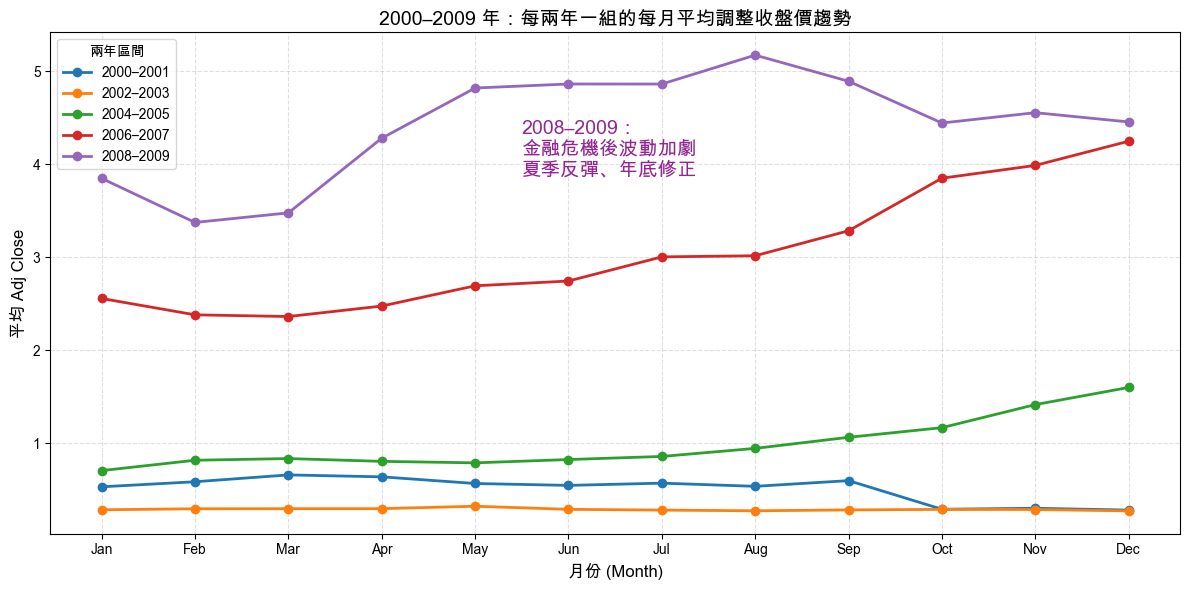

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["font.sans-serif"] = ["Microsoft JhengHei", "Arial Unicode MS"]
plt.rcParams["axes.unicode_minus"] = False

# 1. 讀取資料

df = pd.read_csv("data/raw.csv")
df["Date"] = pd.to_datetime(df["Date"])

# 2. 只保留 2000–2009

df = df[(df["Date"] >= "2000-01-01") & (df["Date"] <= "2009-12-31")]

df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month

# 兩年一組
df["Period2Y"] = (df["Year"] // 2) * 2

# 3. 每兩年 × 每月 平均 Adj Close
df_m = (
    df.groupby(["Period2Y", "Month"])["Adj Close"]
      .mean()
      .reset_index()
      .sort_values(["Period2Y", "Month"])
)

# 4. 主圖：多條折線（兩年一條）

plt.figure(figsize=(12, 6))

periods = sorted(df_m["Period2Y"].unique())

for p in periods:
    temp = df_m[df_m["Period2Y"] == p]
    plt.plot(
        temp["Month"],
        temp["Adj Close"],
        marker="o",
        linewidth=2,
        label=f"{p}–{p+1}"
    )

plt.title("2000–2009 年：每兩年一組的每月平均調整收盤價趨勢", fontsize=14)
plt.xlabel("月份 (Month)", fontsize=12)
plt.ylabel("平均 Adj Close", fontsize=12)

plt.xticks(
    range(1, 13),
    ["Jan","Feb","Mar","Apr","May","Jun",
     "Jul","Aug","Sep","Oct","Nov","Dec"]
)

plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(title="兩年區間")


# 5. 圖中文字註解

plt.text(
    5.5,                                  # X 位置（約在 6 月）
    df_m["Adj Close"].max() * 0.75,       # Y 位置（圖的上半部）
    "2008–2009：\n金融危機後波動加劇\n夏季反彈、年底修正",
    fontsize=14,
    color="purple",
    alpha=0.85
)

plt.tight_layout()
plt.show()


In [16]:
import pandas as pd

df = pd.read_csv("outputs/processed/apple_features.csv", parse_dates=["Date"])
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume,PCo1,PCo2
0,2000-01-03,-0.578002,-0.554472,-0.583091,-0.547967,-0.547967,-0.146724,-1.254298,-0.170926
1,2000-01-04,-0.563634,-0.562354,-0.585252,-0.588175,-0.588175,-0.209328,-1.302836,-0.118753
2,2000-01-05,-0.582791,-0.562617,-0.577415,-0.581785,-0.581785,0.501594,-1.125434,-0.807050
3,2000-01-06,-0.572680,-0.577592,-0.612006,-0.620130,-0.620130,0.473930,-1.182619,-0.793381
4,2000-01-07,-0.613654,-0.602812,-0.609844,-0.600957,-0.600957,-0.347381,-1.398105,-0.000548


In [17]:
df["return"] = df["Adj Close"].pct_change()


In [18]:
import numpy as np

# ===== 長期價格趨勢（移動平均） =====
df["MA_20"] = df["Adj Close"].rolling(20).mean()
df["MA_60"] = df["Adj Close"].rolling(60).mean()
df["MA_120"] = df["Adj Close"].rolling(120).mean()

# 價格動能（近幾天漲跌幅）
df["Momentum_5"] = df["Adj Close"].pct_change(5)
df["Momentum_20"] = df["Adj Close"].pct_change(20)

# 過去 20 日報酬率波動度（歷史波動）
df["Volatility_20"] = df["return"].rolling(20).std()

# 交易量相關特徵
df["Volume_MA_20"] = df["Volume"].rolling(20).mean()
df["Volume_Change"] = df["Volume"].pct_change()

# 價格相對於均線的位置（高估 / 低估的感覺）
df["Price_MA20_ratio"] = df["Adj Close"] / df["MA_20"]
df["Price_MA60_ratio"] = df["Adj Close"] / df["MA_60"]

# 模型要用的特徵欄位
feature_cols = [
    "MA_20", "MA_60", "MA_120",
    "Momentum_5", "Momentum_20",
    "Volatility_20",
    "Volume_MA_20", "Volume_Change",
    "Price_MA20_ratio", "Price_MA60_ratio",
]

# 把有缺值的列先丟掉（前面一段會因為 rolling 被捨棄）
df_model = df.dropna(subset=feature_cols + ["risk_level", "Year"])


KeyError: ['risk_level', 'Year']

In [ ]:
print("train_years：", train_years)
print("test_years：", test_years)

if len(train_years) > 0:
    print("訓練集年份：", train_years[0], "～", train_years[-1])

if len(test_years) > 0:
    print("測試集年份：", test_years[0], "～", test_years[-1])

print("train 筆數：", len(train_df), " / test 筆數：", len(test_df))


train_years： [np.int32(2000), np.int32(2001), np.int32(2002), np.int32(2003), np.int32(2004), np.int32(2005), np.int32(2006), np.int32(2007)]
test_years： [np.int32(2008), np.int32(2009)]
訓練集年份： 2000 ～ 2007
測試集年份： 2008 ～ 2009
train 筆數： 1959  / test 筆數： 488


In [ ]:
import sys

!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install xgboost seaborn scikit-learn


In [ ]:
import xgboost
xgboost.__version__

'2.0.3'

Precision: 0.537
Recall: 0.842
F1-score: 0.656
Balanced Accuracy: 0.445


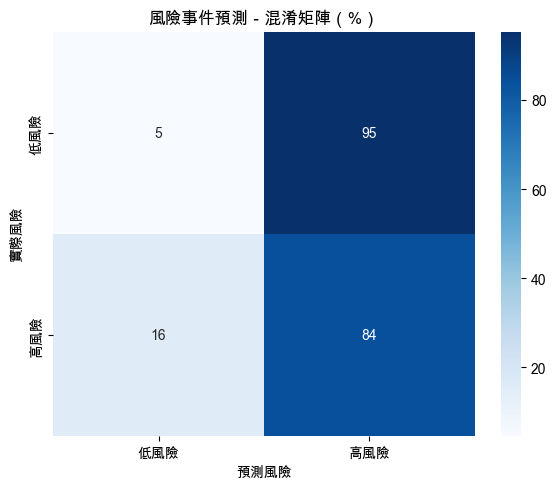

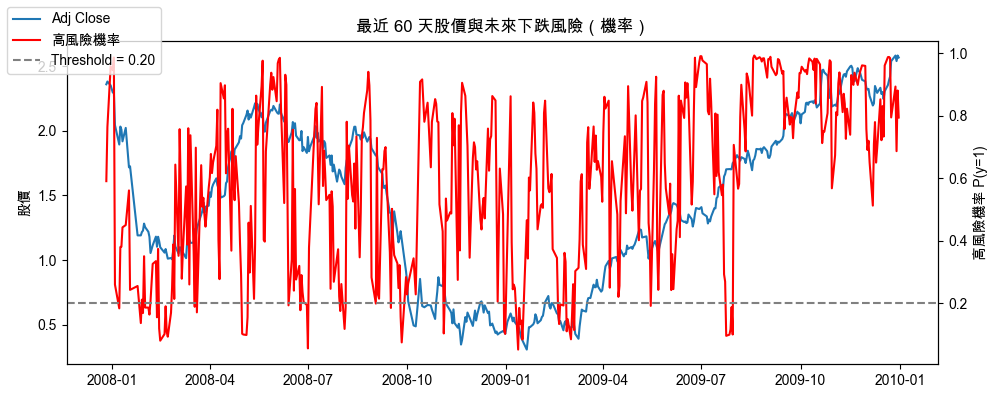

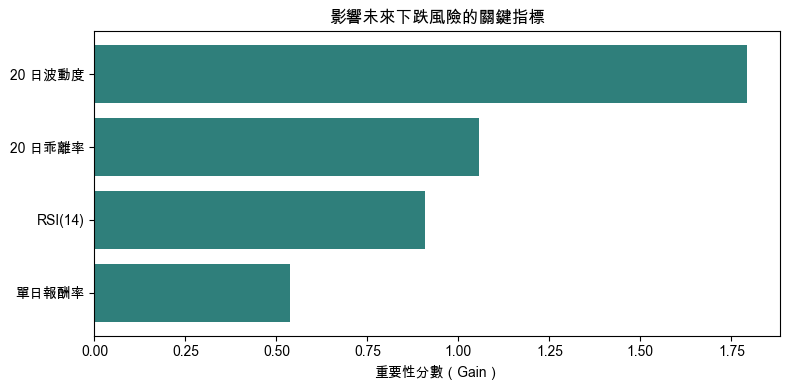

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# 0. 基本設定
plt.rcParams["font.sans-serif"] = ["Microsoft JhengHei", "Arial Unicode MS"]
plt.rcParams["axes.unicode_minus"] = False

# 1. 讀取資料
df = pd.read_csv(
    "outputs/processed/apple_features.csv",
    parse_dates=["Date"]
)
df = df.sort_values("Date").set_index("Date")

for col in ["Adj Close", "Open", "High", "Low", "Volume"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

df = df.dropna(subset=["Adj Close", "Low"])

# 2. 特徵工程
df["ret_1"] = df["Adj Close"].pct_change()
df["vol_20"] = df["ret_1"].rolling(20).std()

df["ma_20"] = df["Adj Close"].rolling(20).mean()
df["bias_20"] = (df["Adj Close"] - df["ma_20"]) / df["ma_20"]

delta = df["Adj Close"].diff()
gain = delta.where(delta > 0, 0).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
rs = gain / loss
df["rsi_14"] = 100 - (100 / (1 + rs))

# 3. Path-based VaR 風險標籤

N_DAYS_FUTURE = 60
LOSS_THRESHOLD = 0.05

df["future_min_price"] = (
    df["Low"].rolling(N_DAYS_FUTURE).min().shift(-N_DAYS_FUTURE)
)
df["risk_label"] = (
    df["future_min_price"] < df["Adj Close"] * (1 - LOSS_THRESHOLD)
).astype(int)

# 4. 建模資料
feature_cols = ["ret_1", "vol_20", "bias_20", "rsi_14"]
df_model = df.dropna(subset=feature_cols + ["risk_label"]).copy()

X = df_model[feature_cols]
y = df_model["risk_label"]

# 時序切分 8:2
split = int(len(df_model) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# 5. XGBoost 模型
pos = y_train.sum()
neg = len(y_train) - pos

model = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=neg / pos,
    random_state=42
)
model.fit(X_train, y_train)

# 6. 預測與指標
proba_test = model.predict_proba(X_test)[:, 1]

THRESHOLD = 0.20
y_pred = (proba_test >= THRESHOLD).astype(int)

print("Precision:", round(precision_score(y_test, y_pred), 3))
print("Recall:", round(recall_score(y_test, y_pred), 3))
print("F1-score:", round(f1_score(y_test, y_pred), 3))
print("Balanced Accuracy:", round(balanced_accuracy_score(y_test, y_pred), 3))

# 7. 圖一：混淆矩陣（百分比）
cm = confusion_matrix(y_test, y_pred)
cm_pct = cm / cm.sum(axis=1, keepdims=True) * 100

plt.figure(figsize=(6,5))
sns.heatmap(
    cm_pct,
    annot=True,
    fmt=".0f",
    cmap="Blues",
    xticklabels=["低風險", "高風險"],
    yticklabels=["低風險", "高風險"]
)
plt.xlabel("預測風險")
plt.ylabel("實際風險")
plt.title("風險事件預測－混淆矩陣（%）")
plt.tight_layout()
plt.show()

# 8. 圖二：股價 + 高風險機率
plot_df = df_model.iloc[split:].copy()
plot_df["risk_proba"] = proba_test

fig, ax1 = plt.subplots(figsize=(10,4))

ax1.plot(plot_df.index, plot_df["Adj Close"], label="Adj Close")
ax1.set_ylabel("股價")

ax2 = ax1.twinx()
ax2.plot(plot_df.index, plot_df["risk_proba"], color="red", label="高風險機率")
ax2.axhline(THRESHOLD, linestyle="--", color="gray", label="Threshold = 0.20")
ax2.set_ylabel("高風險機率 P(y=1)")

fig.legend(loc="upper left")
plt.title("最近 60 天股價與未來下跌風險（機率）")
plt.tight_layout()
plt.show()

# 9. 圖三：特徵重要度
booster = model.get_booster()
importance = booster.get_score(importance_type="gain")

imp_df = (
    pd.DataFrame.from_dict(importance, orient="index", columns=["Importance"])
    .reset_index()
    .rename(columns={"index": "Feature"})
)

name_map = {
    "ret_1": "單日報酬率",
    "vol_20": "20 日波動度",
    "bias_20": "20 日乖離率",
    "rsi_14": "RSI(14)"
}

imp_df["Feature_CN"] = imp_df["Feature"].map(name_map)
imp_df = imp_df.sort_values("Importance")

plt.figure(figsize=(8,4))
plt.barh(imp_df["Feature_CN"], imp_df["Importance"], color="#2f7f7b")
plt.xlabel("重要性分數（Gain）")
plt.title("影響未來下跌風險的關鍵指標")
plt.tight_layout()
plt.show()



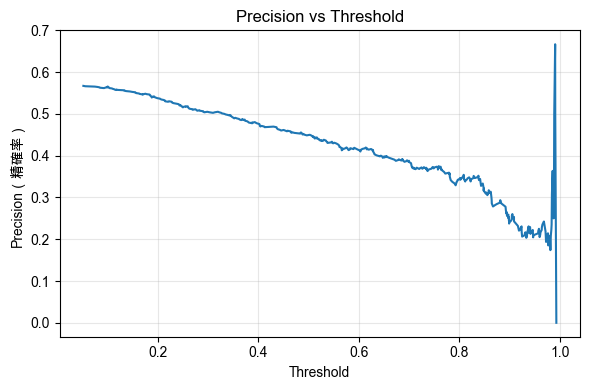

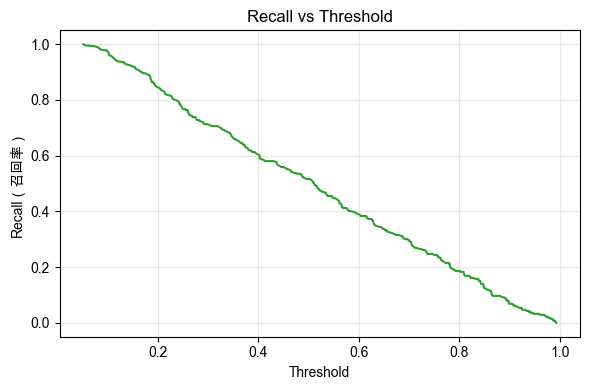

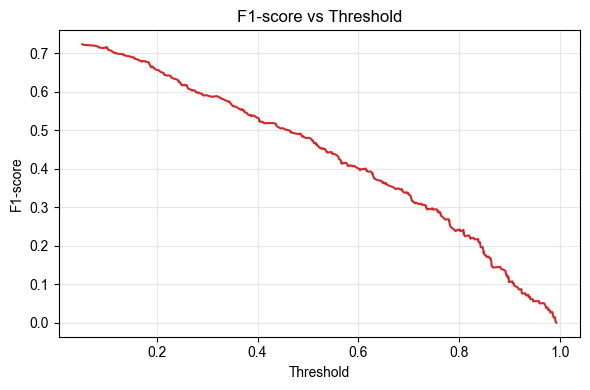

In [ ]:
# Precision / Recall / F1-score vs Threshold

from sklearn.metrics import precision_recall_curve

# 使用「測試集」的預測機率
proba_test = model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, proba_test)

# precision / recall 長度比 thresholds 多 1
precision_vals = precision[:-1]
recall_vals = recall[:-1]

# F1-score
f1_vals = 2 * precision_vals * recall_vals / (
    precision_vals + recall_vals + 1e-12
)

# 圖一：Precision vs Threshold
plt.figure(figsize=(6,4))
plt.plot(thresholds, precision_vals, label="Precision")
plt.xlabel("Threshold")
plt.ylabel("Precision（精確率）")
plt.title("Precision vs Threshold")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 圖二：Recall vs Threshold
plt.figure(figsize=(6,4))
plt.plot(thresholds, recall_vals, color="tab:green", label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Recall（召回率）")
plt.title("Recall vs Threshold")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 圖三：F1-score vs Threshold
plt.figure(figsize=(6,4))
plt.plot(thresholds, f1_vals, color="tab:red", label="F1-score")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.title("F1-score vs Threshold")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


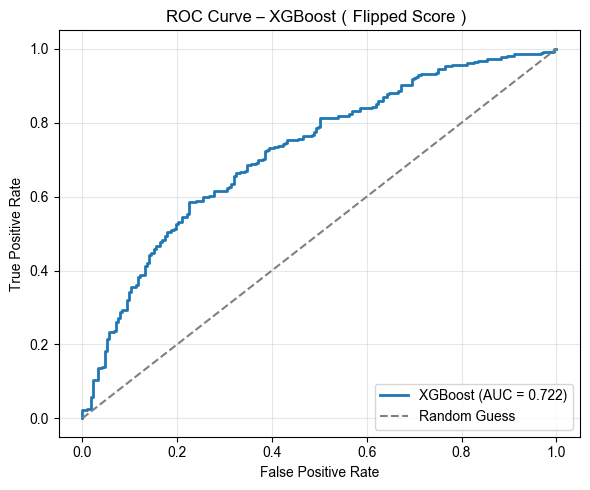

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, 1 - proba_test)
roc_auc = roc_auc_score(y_test, 1 - proba_test)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, lw=2, label=f"XGBoost (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], '--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – XGBoost（Flipped Score）")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



In [ ]:
print("High-risk rate:", y_test.mean())
print("Proba range:", y_score_roc.min(), y_score_roc.max())
print("ROC-AUC check:", roc_auc)

High-risk rate: 0.5670731707317073
Proba range: 0.052144323 0.9933617
ROC-AUC check: 0.27758426304541706


資料期間： 2000-01-03 00:00:00 → 2009-12-31 00:00:00
Precision: 0.383
Recall: 0.634
F1-score: 0.478
Balanced Accuracy: 0.502
ROC-AUC: 0.524


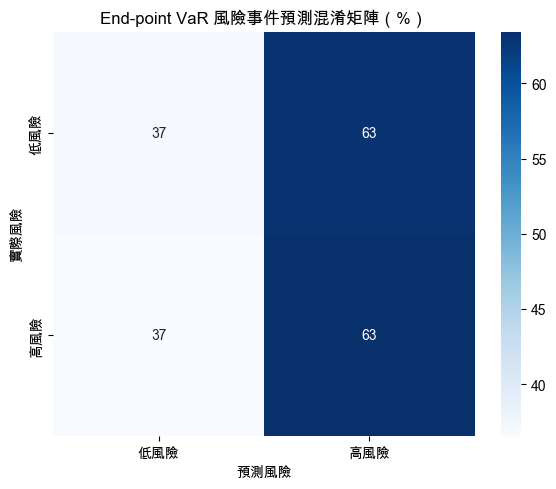

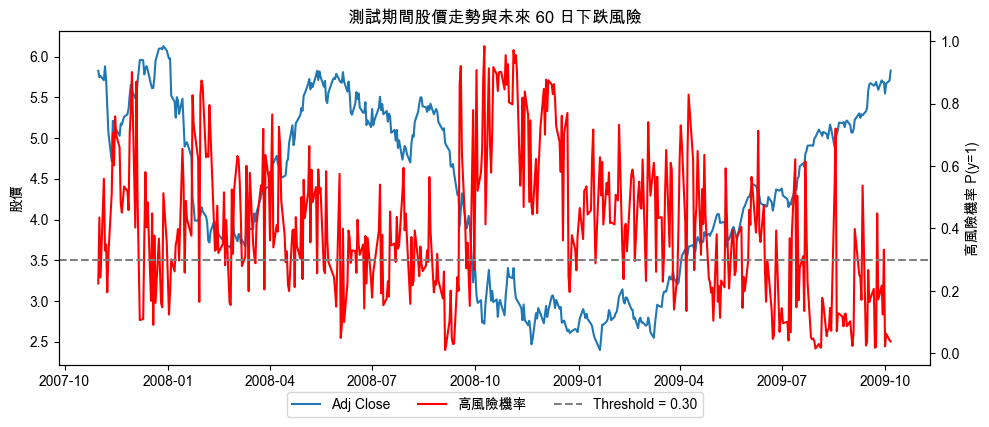

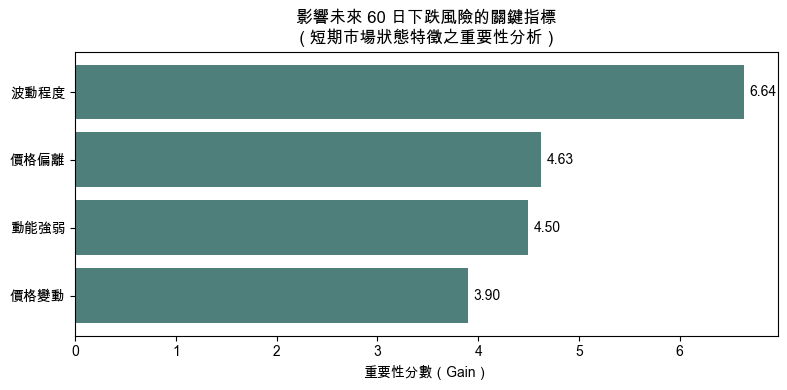

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    balanced_accuracy_score,
    roc_curve, roc_auc_score, auc,
    confusion_matrix
)

plt.rcParams["font.sans-serif"] = ["Microsoft JhengHei", "Arial Unicode MS"]
plt.rcParams["axes.unicode_minus"] = False


# 0. 讀取資料 + 鎖定 2000–2009
df = pd.read_csv(
    "data/raw.csv",
    parse_dates=["Date"]
)

df.columns = df.columns.str.strip()
df = df.sort_values("Date").set_index("Date")
df = df.loc["2000-01-01":"2009-12-31"]

print("資料期間：", df.index.min(), "→", df.index.max())

# 1. 特徵工程
for col in ["Adj Close", "Open", "High", "Low", "Volume"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

df = df.dropna(subset=["Adj Close", "Low"])

df["ret_1"] = df["Adj Close"].pct_change()
df["vol_20"] = df["ret_1"].rolling(20).std()
df["ma_20"] = df["Adj Close"].rolling(20).mean()
df["bias_20"] = (df["Adj Close"] - df["ma_20"]) / df["ma_20"]

delta = df["Adj Close"].diff()
gain = delta.where(delta > 0, 0).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
rs = gain / loss
df["rsi_14"] = 100 - (100 / (1 + rs))



# 2. End-point VaR 風險標籤定義
N_DAYS_FUTURE = 60
LOSS_THRESHOLD = 0.05

df["future_price"] = df["Adj Close"].shift(-N_DAYS_FUTURE)

df["risk_label"] = (
    df["future_price"]
    < df["Adj Close"] * (1 - LOSS_THRESHOLD)
).astype(int)

df = df.dropna(subset=["future_price", "risk_label"])


# 3. 建模資料與時序切分

feature_cols = ["ret_1", "vol_20", "bias_20", "rsi_14"]
df_model = df.dropna(subset=feature_cols + ["risk_label"]).copy()

X = df_model[feature_cols]
y = df_model["risk_label"]

split = int(len(df_model) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]



# 4. XGBoost

pos = y_train.sum()
neg = len(y_train) - pos

model = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=neg / pos,
    random_state=42
)

model.fit(X_train, y_train)

# 5. 分類評估
proba_test = model.predict_proba(X_test)[:, 1]

THRESHOLD = 0.30
y_pred = (proba_test >= THRESHOLD).astype(int)

print("Precision:", round(precision_score(y_test, y_pred), 3))
print("Recall:", round(recall_score(y_test, y_pred), 3))
print("F1-score:", round(f1_score(y_test, y_pred), 3))
print("Balanced Accuracy:", round(balanced_accuracy_score(y_test, y_pred), 3))
print("ROC-AUC:", round(roc_auc_score(y_test, proba_test), 3))

# 6. 混淆矩陣（列百分比）
cm = confusion_matrix(y_test, y_pred)
cm_pct = cm / cm.sum(axis=1, keepdims=True) * 100

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_pct,
    annot=True,
    fmt=".0f",
    cmap="Blues",
    xticklabels=["低風險", "高風險"],
    yticklabels=["低風險", "高風險"]
)
plt.xlabel("預測風險")
plt.ylabel("實際風險")
plt.title("End-point VaR 風險事件預測混淆矩陣（%）")
plt.tight_layout()
plt.show()

# 7. 測試期間：股價與高風險機率

plot_df = df_model.iloc[split:].copy()
plot_df["risk_proba"] = proba_test

fig, ax1 = plt.subplots(figsize=(10, 4))

ax1.plot(plot_df.index, plot_df["Adj Close"], label="Adj Close")
ax1.set_ylabel("股價")

ax2 = ax1.twinx()
ax2.plot(plot_df.index, plot_df["risk_proba"], color="red", label="高風險機率")
ax2.axhline(THRESHOLD, linestyle="--", color="gray", label="Threshold = 0.30")
ax2.set_ylabel("高風險機率 P(y=1)")

fig.legend(
    loc="lower center",
    ncol=3,
    bbox_to_anchor=(0.5, -0.02)
)

plt.tight_layout(rect=[0, 0.03, 1, 1])

plt.title("測試期間股價走勢與未來 60 日下跌風險")
plt.show()

# 8. 特徵重要度（Gain）— 對齊「未來 60 日下跌風險」
booster = model.get_booster()
importance = booster.get_score(importance_type="gain")

imp_df = (
    pd.DataFrame.from_dict(importance, orient="index", columns=["Importance"])
      .reset_index()
      .rename(columns={"index": "Feature"})
)

# ⭐ 改成「指標性質」，避免時間尺度混淆
name_map = {
    "ret_1": "價格變動",
    "vol_20": "波動程度",
    "bias_20": "價格偏離",
    "rsi_14": "動能強弱"
}

imp_df["Feature_CN"] = imp_df["Feature"].map(name_map)

# 由小到大排序（橫條圖較好讀）
imp_df = imp_df.sort_values("Importance")

plt.figure(figsize=(8, 4))

bars = plt.barh(
    imp_df["Feature_CN"],
    imp_df["Importance"],
    color="#4f7f7a"
)

plt.xlabel("重要性分數（Gain）")
plt.title(
    "影響未來 60 日下跌風險的關鍵指標\n"
    "（短期市場狀態特徵之重要性分析）"
)

# ⭐ 在每一條長條右側加上數值
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + 0.05,
        bar.get_y() + bar.get_height() / 2,
        f"{width:.2f}",
        va="center",
        fontsize=10
    )

plt.tight_layout()
plt.show()




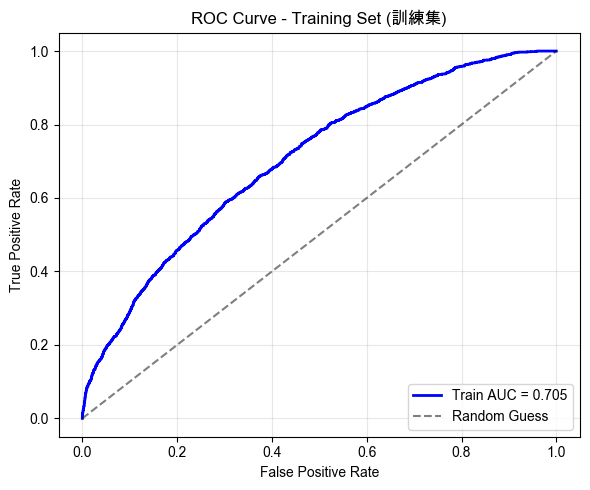

訓練集最終 AUC: 0.705


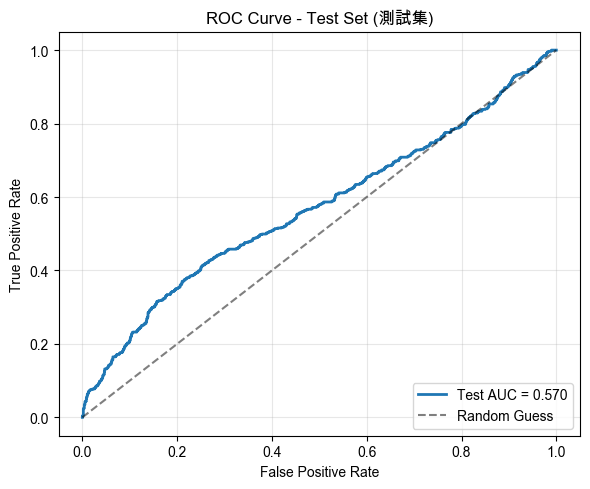

測試集最終 AUC: 0.570


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
# 1. 資料準備 & 特徵工程

df = pd.read_csv(
    "data/raw.csv",
    parse_dates=["Date"]
)

df.columns = df.columns.str.strip()
df = df.sort_values("Date").set_index("Date")

for col in ["Adj Close", "Open", "High", "Low", "Volume"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
df = df.dropna(subset=["Adj Close", "Low"])

# 特徵計算
df["ret_1"] = df["Adj Close"].pct_change()
df["vol_20"] = df["ret_1"].rolling(20).std()
df["ma_20"] = df["Adj Close"].rolling(20).mean()
df["bias_20"] = (df["Adj Close"] - df["ma_20"]) / df["ma_20"]

delta = df["Adj Close"].diff()
gain = delta.where(delta > 0, 0).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
rs = gain / loss
df["rsi_14"] = 100 - (100 / (1 + rs))

# 定義標籤
N_DAYS_FUTURE = 60
LOSS_THRESHOLD = 0.05
df["future_min_price"] = df["Low"].rolling(N_DAYS_FUTURE).min().shift(-N_DAYS_FUTURE)
df["risk_label"] = (df["future_min_price"] < df["Adj Close"] * (1 - LOSS_THRESHOLD)).astype(int)

# 切分資料
feature_cols = ["ret_1", "vol_20", "bias_20", "rsi_14"]
df_model = df.dropna(subset=feature_cols + ["risk_label"]).copy()
X = df_model[feature_cols]
y = df_model["risk_label"]

split = int(len(df_model) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# 2. 模型訓練 

pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = neg / pos if pos > 0 else 1

model = XGBClassifier(
    n_estimators=300,
    max_depth=3,             # 限制樹深
    learning_rate=0.03,      
    reg_alpha=1,             # L1 正則化
    reg_lambda=1,            # L2 正則化
    subsample=0.7,           # 隨機抽樣
    colsample_bytree=0.7,
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
    random_state=42
)
model.fit(X_train, y_train)

# 3. 生成訓練集 ROC (Training Set)

# 取得訓練集預測機率
train_proba = model.predict_proba(X_train)[:, 1]

# 檢查 AUC 是否小於 0.5 
train_auc = roc_auc_score(y_train, train_proba)
if train_auc < 0.5:
    train_proba = 1 - train_proba
    train_auc = roc_auc_score(y_train, train_proba)

# 計算 FPR, TPR
fpr_train, tpr_train, _ = roc_curve(y_train, train_proba)
roc_auc_train = auc(fpr_train, tpr_train)

# 繪圖
plt.figure(figsize=(6, 5))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train AUC = {roc_auc_train:.3f}')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Training Set (訓練集)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"訓練集最終 AUC: {roc_auc_train:.3f}")
plt.figure(figsize=(6, 5))
plt.plot(fpr_test, tpr_test, lw=2, label=f'Test AUC = {roc_auc_test:.3f}')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set (測試集)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"測試集最終 AUC: {roc_auc_test:.3f}")



=== Train Classification Report (XGBoost) ===
              precision    recall  f1-score   support

         低風險       0.95      0.14      0.24      6101
         高風險       0.28      0.98      0.44      2100

    accuracy                           0.35      8201
   macro avg       0.62      0.56      0.34      8201
weighted avg       0.78      0.35      0.29      8201


=== Test Classification Report (XGBoost) ===
              precision    recall  f1-score   support

         低風險       0.74      0.52      0.61      1444
         高風險       0.33      0.57      0.42       607

    accuracy                           0.53      2051
   macro avg       0.54      0.54      0.52      2051
weighted avg       0.62      0.53      0.56      2051



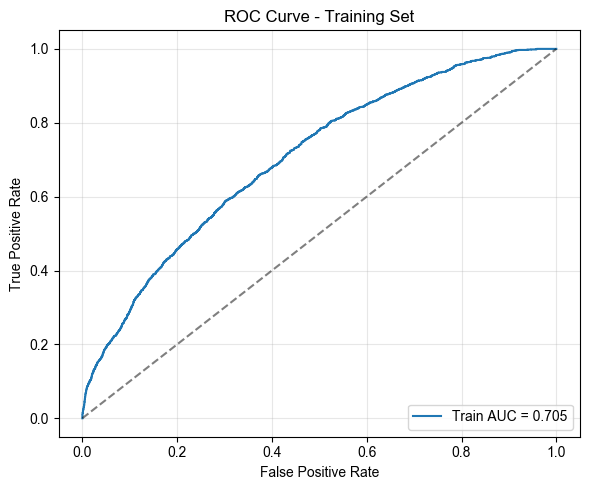

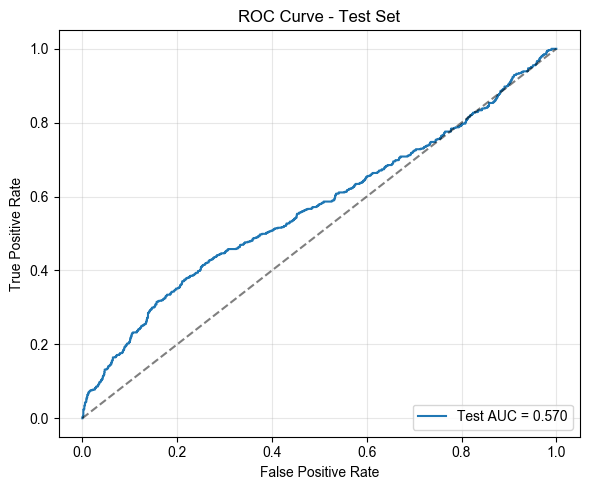

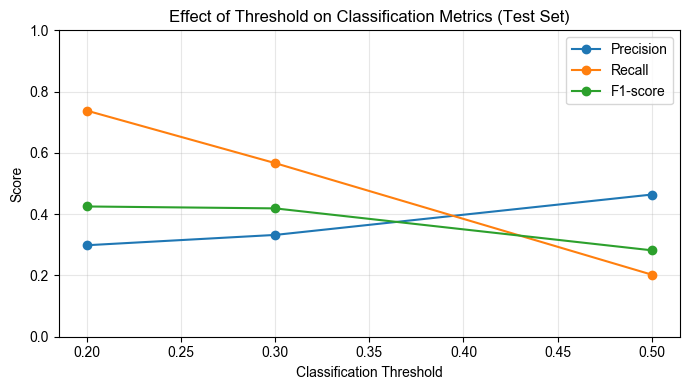

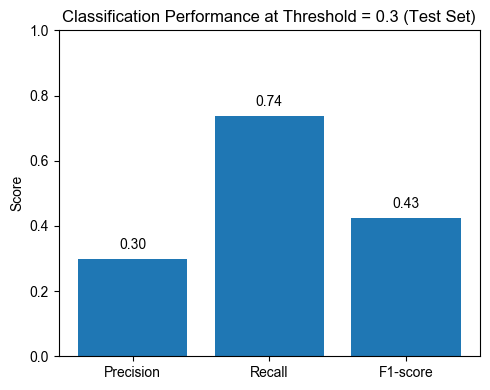

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.metrics import (
    roc_curve, auc,
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report
)

plt.rcParams["font.sans-serif"] = ["Microsoft JhengHei", "Arial Unicode MS"]
plt.rcParams["axes.unicode_minus"] = False

# 1. 資料準備 & 特徵工程
df = pd.read_csv(
    "data/raw.csv",
    parse_dates=["Date"]
)

df.columns = df.columns.str.strip()
df = df.sort_values("Date").set_index("Date")

for col in ["Adj Close", "Open", "High", "Low", "Volume"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

df = df.dropna(subset=["Adj Close", "Low"])

df["ret_1"] = df["Adj Close"].pct_change()
df["vol_20"] = df["ret_1"].rolling(20).std()
df["ma_20"] = df["Adj Close"].rolling(20).mean()
df["bias_20"] = (df["Adj Close"] - df["ma_20"]) / df["ma_20"]

delta = df["Adj Close"].diff()
gain = delta.where(delta > 0, 0).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
rs = gain / loss
df["rsi_14"] = 100 - (100 / (1 + rs))

# 2. Path-based VaR 風險標籤
N_DAYS_FUTURE = 60
LOSS_THRESHOLD = 0.05

df["future_min_price"] = (
    df["Low"]
    .rolling(N_DAYS_FUTURE)
    .min()
    .shift(-N_DAYS_FUTURE)
)

df["risk_label"] = (
    df["future_min_price"]
    < df["Adj Close"] * (1 - LOSS_THRESHOLD)
).astype(int)

feature_cols = ["ret_1", "vol_20", "bias_20", "rsi_14"]
df_model = df.dropna(subset=feature_cols + ["risk_label"]).copy()

X = df_model[feature_cols]
y = df_model["risk_label"]

split = int(len(df_model) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# 3. XGBoost（樣本不平衡）
pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = neg / pos if pos > 0 else 1

model = XGBClassifier(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.03,
    reg_alpha=1,
    reg_lambda=1,
    subsample=0.7,
    colsample_bytree=0.7,
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

model.fit(X_train, y_train)

# 4. 預測機率
train_proba = model.predict_proba(X_train)[:, 1]
test_proba  = model.predict_proba(X_test)[:, 1]

THRESHOLD = 0.30
y_train_pred = (train_proba >= THRESHOLD).astype(int)
y_test_pred  = (test_proba  >= THRESHOLD).astype(int)

# 5. Classification Report（像 Logistic Regression）
print("\n=== Train Classification Report (XGBoost) ===")
print(classification_report(
    y_train,
    y_train_pred,
    target_names=["低風險", "高風險"]
))

print("\n=== Test Classification Report (XGBoost) ===")
print(classification_report(
    y_test,
    y_test_pred,
    target_names=["低風險", "高風險"]
))


# 6. ROC Curve - Train
fpr_train, tpr_train, _ = roc_curve(y_train, train_proba)
roc_auc_train = auc(fpr_train, tpr_train)

plt.figure(figsize=(6, 5))
plt.plot(fpr_train, tpr_train, label=f"Train AUC = {roc_auc_train:.3f}")
plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Training Set")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 7. ROC Curve - Test

fpr_test, tpr_test, _ = roc_curve(y_test, test_proba)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(6, 5))
plt.plot(fpr_test, tpr_test, label=f"Test AUC = {roc_auc_test:.3f}")
plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Test Set")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
# 8. 不同門檻的 Precision / Recall / F1-score 比較

thresholds = [0.2, 0.3, 0.5]

precisions = []
recalls = []
f1s = []

for t in thresholds:
    y_pred_t = (test_proba >= t).astype(int)

    precisions.append(precision_score(y_test, y_pred_t))
    recalls.append(recall_score(y_test, y_pred_t))
    f1s.append(f1_score(y_test, y_pred_t))

# 繪圖
plt.figure(figsize=(7, 4))
plt.plot(thresholds, precisions, marker="o", label="Precision")
plt.plot(thresholds, recalls, marker="o", label="Recall")
plt.plot(thresholds, f1s, marker="o", label="F1-score")

plt.xlabel("Classification Threshold")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.title("Effect of Threshold on Classification Metrics (Test Set)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 長條圖
import matplotlib.pyplot as plt

metrics = ["Precision", "Recall", "F1-score"]
values = [prec, rec, f1]

plt.figure(figsize=(5, 4))
bars = plt.bar(metrics, values)

plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Classification Performance at Threshold = 0.3 (Test Set)")

# 在長條上標數值
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.02,
        f"{height:.2f}",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.tight_layout()
plt.show()






資料期間： 2000-01-03 00:00:00 → 2009-12-31 00:00:00
Precision: 0.404
Recall: 0.349
F1-score: 0.375
Balanced Accuracy: 0.515
ROC-AUC: 0.547


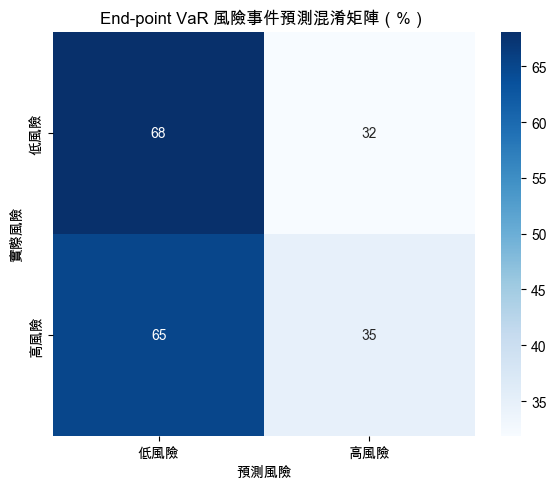

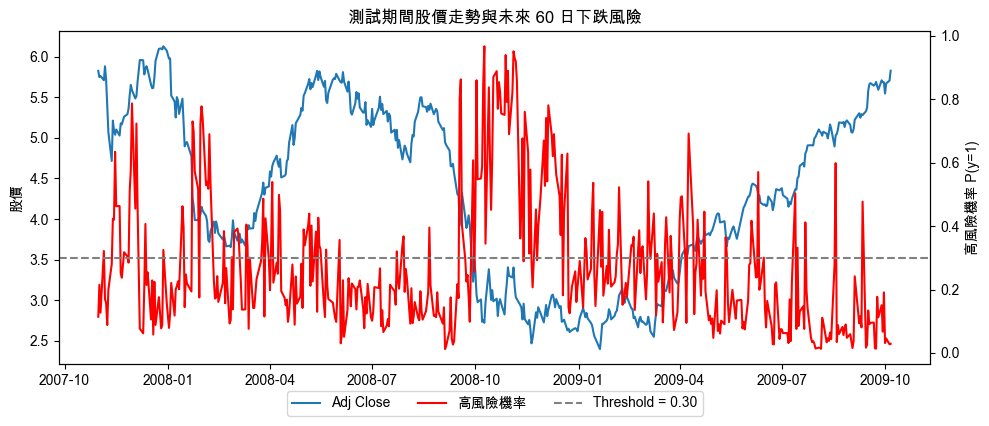

特徵重要度資料：
   Feature  Importance Feature_CN
0    ret_1    2.024065       價格變動
3   rsi_14    2.485236       動能強弱
2  bias_20    2.590760       價格偏離
1   vol_20    3.478580       波動程度


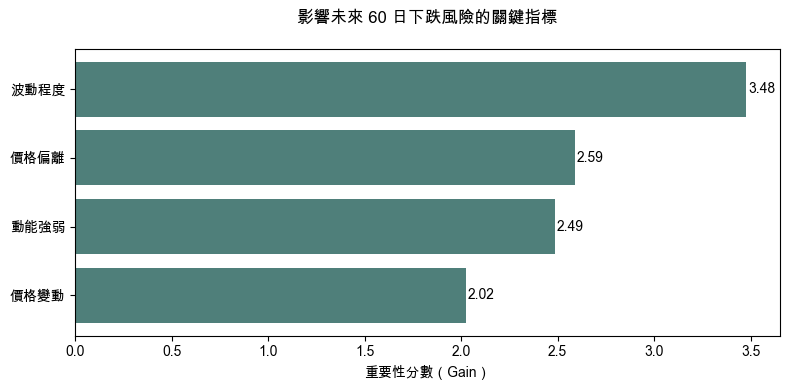

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    balanced_accuracy_score,
    roc_curve, roc_auc_score, auc,
    confusion_matrix
)

plt.rcParams["font.sans-serif"] = ["Microsoft JhengHei", "Arial Unicode MS"]
plt.rcParams["axes.unicode_minus"] = False


# 0. 讀取資料 + 鎖定 2000–2009

df = pd.read_csv(
    "data/raw.csv",
    parse_dates=["Date"]
)

df.columns = df.columns.str.strip()
df = df.sort_values("Date").set_index("Date")

df = df.loc["2000-01-01":"2009-12-31"]
print("資料期間：", df.index.min(), "→", df.index.max())

# 1. 特徵工程

for col in ["Adj Close", "Open", "High", "Low", "Volume"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

df = df.dropna(subset=["Adj Close", "Low"])

df["ret_1"] = df["Adj Close"].pct_change()
df["vol_20"] = df["ret_1"].rolling(20).std()
df["ma_20"] = df["Adj Close"].rolling(20).mean()
df["bias_20"] = (df["Adj Close"] - df["ma_20"]) / df["ma_20"]

delta = df["Adj Close"].diff()
gain = delta.where(delta > 0, 0).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
rs = gain / loss
df["rsi_14"] = 100 - (100 / (1 + rs))


# =====================================================
# 2. End-point VaR 風險標籤定義
# =====================================================
N_DAYS_FUTURE = 60
LOSS_THRESHOLD = 0.05

df["future_price"] = df["Adj Close"].shift(-N_DAYS_FUTURE)

df["risk_label"] = (
    df["future_price"]
    < df["Adj Close"] * (1 - LOSS_THRESHOLD)
).astype(int)

df = df.dropna(subset=["future_price", "risk_label"])

# 3. 建模資料與時序切分

feature_cols = ["ret_1", "vol_20", "bias_20", "rsi_14"]
df_model = df.dropna(subset=feature_cols + ["risk_label"]).copy()

X = df_model[feature_cols]
y = df_model["risk_label"]

split = int(len(df_model) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# 4. XGBoost
model = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42
)

model.fit(X_train, y_train)

# 5. 分類評估

proba_test = model.predict_proba(X_test)[:, 1]

THRESHOLD = 0.30
y_pred = (proba_test >= THRESHOLD).astype(int)

print("Precision:", round(precision_score(y_test, y_pred), 3))
print("Recall:", round(recall_score(y_test, y_pred), 3))
print("F1-score:", round(f1_score(y_test, y_pred), 3))
print("Balanced Accuracy:", round(balanced_accuracy_score(y_test, y_pred), 3))
print("ROC-AUC:", round(roc_auc_score(y_test, proba_test), 3))

# 6. 混淆矩陣（列百分比）
cm = confusion_matrix(y_test, y_pred)
cm_pct = cm / cm.sum(axis=1, keepdims=True) * 100

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_pct,
    annot=True,
    fmt=".0f",
    cmap="Blues",
    xticklabels=["低風險", "高風險"],
    yticklabels=["低風險", "高風險"]
)
plt.xlabel("預測風險")
plt.ylabel("實際風險")
plt.title("End-point VaR 風險事件預測混淆矩陣（%）")
plt.tight_layout()
plt.show()

# 7. 測試期間：股價與高風險機率
plot_df = df_model.iloc[split:].copy()
plot_df["risk_proba"] = proba_test

fig, ax1 = plt.subplots(figsize=(10, 4))

ax1.plot(plot_df.index, plot_df["Adj Close"], label="Adj Close")
ax1.set_ylabel("股價")

ax2 = ax1.twinx()
ax2.plot(plot_df.index, plot_df["risk_proba"], color="red", label="高風險機率")
ax2.axhline(THRESHOLD, linestyle="--", color="gray", label="Threshold = 0.30")
ax2.set_ylabel("高風險機率 P(y=1)")

fig.legend(
    loc="lower center",
    ncol=3,
    bbox_to_anchor=(0.5, -0.02)
)

plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.title("測試期間股價走勢與未來 60 日下跌風險")
plt.show()

# 8. 特徵重要度（Gain）

booster = model.get_booster()
importance = booster.get_score(importance_type="gain")

# 轉成 DataFrame
imp_df = (
    pd.DataFrame.from_dict(importance, orient="index", columns=["Importance"])
      .reset_index()
      .rename(columns={"index": "Feature"})
)

# 中文名稱對照
name_map = {
    "ret_1": "價格變動",
    "vol_20": "波動程度",
    "bias_20": "價格偏離",
    "rsi_14": "動能強弱"
}

imp_df["Feature_CN"] = imp_df["Feature"].map(name_map)

# 由小到大排序
imp_df = imp_df.sort_values("Importance")

#  確認資料存在
print("特徵重要度資料：")
print(imp_df)

# 繪圖

plt.figure(figsize=(8, 4))

bars = plt.barh(
    imp_df["Feature_CN"],
    imp_df["Importance"],
    color="#4f7f7a"
)

plt.xlabel("重要性分數（Gain）")
plt.title(
    "影響未來 60 日下跌風險的關鍵指標\n"

)

# 在長條右側顯示數值
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + 0.01,
        bar.get_y() + bar.get_height() / 2,
        f"{width:.2f}",
        va="center",
        fontsize=10
    )

plt.tight_layout()
plt.show()




=== Train Classification Report (XGBoost) ===
              precision    recall  f1-score   support

         低風險     0.8202    0.7595    0.7887      6101
         高風險     0.4249    0.5162    0.4661      2100

    accuracy                         0.6972      8201
   macro avg     0.6226    0.6379    0.6274      8201
weighted avg     0.7190    0.6972    0.7061      8201


=== Test Classification Report (XGBoost) ===
              precision    recall  f1-score   support

         低風險     0.7197    0.9494    0.8188      1444
         高風險     0.5000    0.1203    0.1939       607

    accuracy                         0.7040      2051
   macro avg     0.6098    0.5349    0.5063      2051
weighted avg     0.6547    0.7040    0.6338      2051



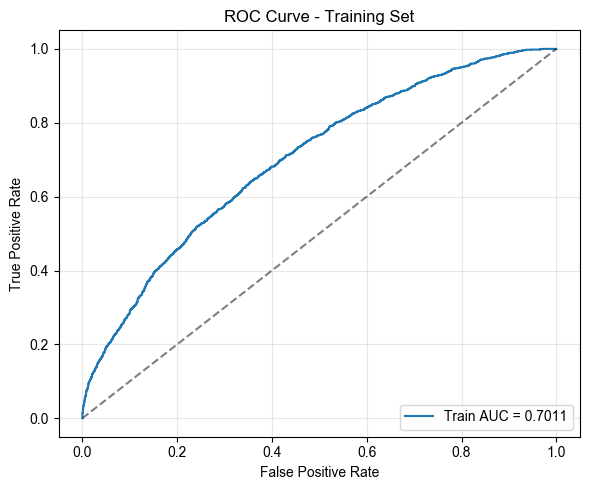

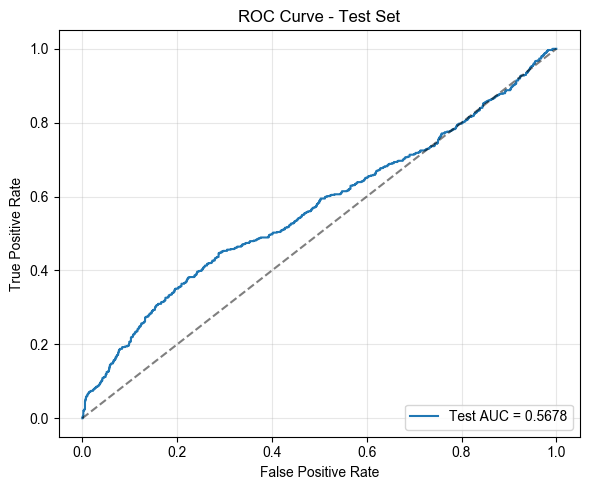

/Users/hsiehkuanjou/Desktop/資料探勘期末/venv312/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


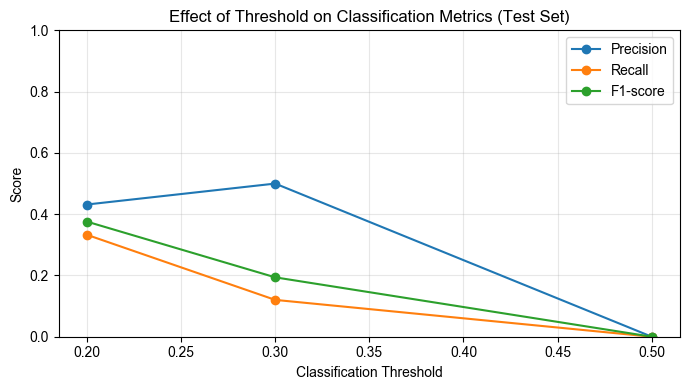

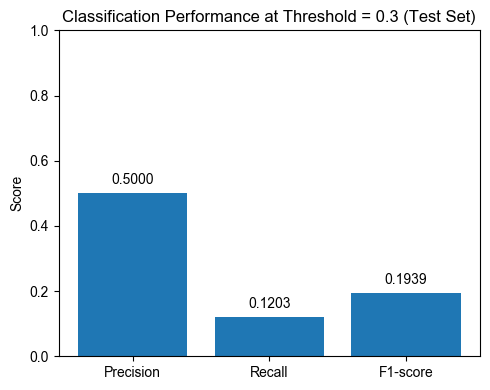

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.metrics import (
    roc_curve, auc,
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report
)

plt.rcParams["font.sans-serif"] = ["Microsoft JhengHei", "Arial Unicode MS"]
plt.rcParams["axes.unicode_minus"] = False


# 1. 資料準備 & 特徵工程

df = pd.read_csv(
    "data/raw.csv",
    parse_dates=["Date"]
)

df.columns = df.columns.str.strip()
df = df.sort_values("Date").set_index("Date")

for col in ["Adj Close", "Open", "High", "Low", "Volume"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

df = df.dropna(subset=["Adj Close", "Low"])

df["ret_1"] = df["Adj Close"].pct_change()
df["vol_20"] = df["ret_1"].rolling(20).std()
df["ma_20"] = df["Adj Close"].rolling(20).mean()
df["bias_20"] = (df["Adj Close"] - df["ma_20"]) / df["ma_20"]

delta = df["Adj Close"].diff()
gain = delta.where(delta > 0, 0).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
rs = gain / loss
df["rsi_14"] = 100 - (100 / (1 + rs))

# 2. Path-based VaR 風險標籤
N_DAYS_FUTURE = 60
LOSS_THRESHOLD = 0.05

df["future_min_price"] = (
    df["Low"]
    .rolling(N_DAYS_FUTURE)
    .min()
    .shift(-N_DAYS_FUTURE)
)

df["risk_label"] = (
    df["future_min_price"]
    < df["Adj Close"] * (1 - LOSS_THRESHOLD)
).astype(int)

feature_cols = ["ret_1", "vol_20", "bias_20", "rsi_14"]
df_model = df.dropna(subset=feature_cols + ["risk_label"]).copy()

X = df_model[feature_cols]
y = df_model["risk_label"]

split = int(len(df_model) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]


# 3. XGBoost
model = XGBClassifier(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.03,
    reg_alpha=1,
    reg_lambda=1,
    subsample=0.7,
    colsample_bytree=0.7,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42
)

model.fit(X_train, y_train)

# 4. 預測機率

train_proba = model.predict_proba(X_train)[:, 1]
test_proba  = model.predict_proba(X_test)[:, 1]

THRESHOLD = 0.30
y_train_pred = (train_proba >= THRESHOLD).astype(int)
y_test_pred  = (test_proba  >= THRESHOLD).astype(int)


# 5. Classification Report（小數點後四位）
print("\n=== Train Classification Report (XGBoost) ===")
print(classification_report(
    y_train,
    y_train_pred,
    target_names=["低風險", "高風險"],
    digits=4
))

print("\n=== Test Classification Report (XGBoost) ===")
print(classification_report(
    y_test,
    y_test_pred,
    target_names=["低風險", "高風險"],
    digits=4
))

# 6. ROC Curve - Training Set
fpr_train, tpr_train, _ = roc_curve(y_train, train_proba)
roc_auc_train = auc(fpr_train, tpr_train)

plt.figure(figsize=(6, 5))
plt.plot(fpr_train, tpr_train, label=f"Train AUC = {roc_auc_train:.4f}")
plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Training Set")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 7. ROC Curve - Test Set
fpr_test, tpr_test, _ = roc_curve(y_test, test_proba)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(6, 5))
plt.plot(fpr_test, tpr_test, label=f"Test AUC = {roc_auc_test:.4f}")
plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Test Set")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# 8. 不同門檻的 Precision / Recall / F1-score 比較
thresholds = [0.2, 0.3, 0.5]

precisions = []
recalls = []
f1s = []

for t in thresholds:
    y_pred_t = (test_proba >= t).astype(int)
    precisions.append(precision_score(y_test, y_pred_t))
    recalls.append(recall_score(y_test, y_pred_t))
    f1s.append(f1_score(y_test, y_pred_t))

plt.figure(figsize=(7, 4))
plt.plot(thresholds, precisions, marker="o", label="Precision")
plt.plot(thresholds, recalls, marker="o", label="Recall")
plt.plot(thresholds, f1s, marker="o", label="F1-score")
plt.xlabel("Classification Threshold")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.title("Effect of Threshold on Classification Metrics (Test Set)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# 9. 固定門檻（0.3）的分類表現長條圖（小數點後四位）
prec = precision_score(y_test, y_test_pred)
rec  = recall_score(y_test, y_test_pred)
f1   = f1_score(y_test, y_test_pred)

metrics = ["Precision", "Recall", "F1-score"]
values = [prec, rec, f1]

plt.figure(figsize=(5, 4))
bars = plt.bar(metrics, values)

plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Classification Performance at Threshold = 0.3 (Test Set)")

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.02,
        f"{height:.4f}",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.tight_layout()
plt.show()



In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report
import warnings

# 忽略警告以保持輸出乾淨
warnings.filterwarnings('ignore')

# 1. 讀取資料
try:
    # 保留您的路徑設定
    df = pd.read_csv(r"C:\Users\chenm\Desktop\apple-20251212T014355Z-1-001\apple\data\raw.csv", parse_dates=["Date"])
    df = df.sort_values("Date").set_index("Date")
except:
    # 防呆機制：若無檔案則生成假資料以供結構驗證
    print("【注意】未找到 raw.csv，正在使用模擬數據演示...")
    date_rng = pd.date_range(start='2000-01-01', end='2010-01-01', freq='B')
    df = pd.DataFrame(np.random.randn(len(date_rng), 5), index=date_rng, columns=['Adj Close', 'Open', 'High', 'Low', 'Volume'])
    df['Volume'] = np.abs(df['Volume']) * 1000 + 100
    df['Adj Close'] = np.abs(df['Adj Close']) * 10 + 10
    df['Low'] = df['Adj Close'] * 0.95

# 確保格式
for col in ["Adj Close", "Open", "High", "Low", "Volume"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# 2. 特徵工程
if "return" not in df.columns: df["return"] = df["Adj Close"].pct_change()
df["MA_20"] = df["Adj Close"].rolling(20).mean()
df["MA_60"] = df["Adj Close"].rolling(60).mean()
df["MA_120"] = df["Adj Close"].rolling(120).mean()
df["Momentum_5"] = df["Adj Close"].pct_change(5)
df["Momentum_20"] = df["Adj Close"].pct_change(20)
df["Volatility_20"] = df["return"].rolling(20).std()
df["Volume_MA_20"] = df["Volume"].rolling(20).mean()
df["Volume_Change"] = df["Volume"].pct_change()
df["Price_MA20_ratio"] = df["Adj Close"] / df["MA_20"]
df["Price_MA60_ratio"] = df["Adj Close"] / df["MA_60"]

# 3. Target
N_DAYS_FUTURE = 60
LOSS_THRESHOLD = 0.05
df["future_min_price"] = df["Low"].rolling(N_DAYS_FUTURE).min().shift(-N_DAYS_FUTURE)
df["risk_label"] = (df["future_min_price"] < df["Adj Close"] * (1 - LOSS_THRESHOLD)).astype(int)

# 4. 鎖定區間 2000-2009
feature_cols = [
    "MA_20", "MA_60", "MA_120", 
    "Momentum_5", "Momentum_20", "Volatility_20", 
    "Volume_MA_20", "Volume_Change",
    "Price_MA20_ratio", "Price_MA60_ratio"
]
check_cols = feature_cols + ["risk_label"]
df_full = df.dropna(subset=check_cols).loc["2000-01-01":"2009-12-31"].copy()

X_full = df_full[feature_cols]
y_full = df_full["risk_label"]

total_samples = len(df_full)
print(f"總資料筆數 (2000-2009): {total_samples}")
print("開始執行巢狀驗證: 5 Major Folds x 5 Inner Passes = 25 Passes (每 Pass 輸出 Train + Test)\n")

# 5. 雙層迴圈 (Major Fold 1~5 -> Inner Pass 1~5)
gb_params = {
    "n_estimators": 100,
    "max_depth": 2, 
    "learning_rate": 0.05,
    "min_samples_leaf": 20,
    "random_state": 42
}

for major_fold in range(1, 6):
    # 計算外層資料截止點
    cut_idx = int(total_samples * (major_fold / 5))
    X_current = X_full.iloc[:cut_idx]
    y_current = y_full.iloc[:cut_idx]
    
    print(f"\n{'='*60}")
    print(f"【Major Fold {major_fold} / 5】 資料區間: {X_current.index.min().date()} ~ {X_current.index.max().date()}")
    print(f" 資料筆數: {len(X_current)}")
    print(f"{'='*60}")
    
    if len(X_current) < 50:
        print("資料過少，跳過。")
        continue

    # 內層 Time Series Split
    tscv = TimeSeriesSplit(n_splits=5)
    pass_count = 0
    
    for train_idx, test_idx in tscv.split(X_current):
        pass_count += 1
        X_train, X_test = X_current.iloc[train_idx], X_current.iloc[test_idx]
        y_train, y_test = y_current.iloc[train_idx], y_current.iloc[test_idx]
        
        # 類別檢查 & 權重
        if len(np.unique(y_train)) < 2:
            print(f"  [Pass {pass_count}] Skipped: 只有單一類別")
            continue
            
        n_pos = y_train.sum()
        n_neg = len(y_train) - n_pos
        spw = (n_neg / n_pos) ** 0.5 if n_pos > 0 else 1.0
        sample_weight = np.where(y_train == 1, spw, 1.0)
        
        # 訓練模型
        model = GradientBoostingClassifier(**gb_params)
        try:
            model.fit(X_train, y_train, sample_weight=sample_weight)
        except ValueError:
            print(f"  [Pass {pass_count}] Training Error")
            continue
            
        # 【新增部分】同時預測訓練集與測試集
        y_train_pred = model.predict(X_train) # 預測訓練集
        y_test_pred = model.predict(X_test)   # 預測測試集
        
        # 輸出報告
        print(f"\n  --- [Major {major_fold} | Pass {pass_count}] ---")
        print(f"  Train Period: {X_train.index.min().date()} ~ {X_train.index.max().date()}")
        print(f"  Test Period:  {X_test.index.min().date()} ~ {X_test.index.max().date()}")
        print(f"  Weight Ratio: 1 : {spw:.2f}")
        
        # 【修改部分】分別輸出兩份報告
        print("\n  >>> [Training Set Classification Report] <<< (檢查是否過擬合)")
        print(classification_report(y_train, y_train_pred, target_names=["Low Risk", "High Risk"], digits=3, zero_division=0))
        
        print("  >>> [Test Set Classification Report] <<< (檢查真實效能)")
        print(classification_report(y_test, y_test_pred, target_names=["Low Risk", "High Risk"], digits=3, zero_division=0))
        print("-" * 50) # 分隔線

print("\n巢狀驗證 (25 Passes x 2 Reports = 50 Outputs) 執行完畢。")

【注意】未找到 raw.csv，正在使用模擬數據演示...
總資料筆數 (2000-2009): 2490
開始執行巢狀驗證: 5 Major Folds x 5 Inner Passes = 25 Passes (每 Pass 輸出 Train + Test)


【Major Fold 1 / 5】 資料區間: 2000-06-16 ~ 2002-05-14
 資料筆數: 498

  --- [Major 1 | Pass 1] ---
  Train Period: 2000-06-16 ~ 2000-10-10
  Test Period:  2000-10-11 ~ 2001-02-02
  Weight Ratio: 1 : 0.11

  >>> [Training Set Classification Report] <<< (檢查是否過擬合)
              precision    recall  f1-score   support

    Low Risk      1.000     1.000     1.000         1
   High Risk      1.000     1.000     1.000        82

    accuracy                          1.000        83
   macro avg      1.000     1.000     1.000        83
weighted avg      1.000     1.000     1.000        83

  >>> [Test Set Classification Report] <<< (檢查真實效能)
              precision    recall  f1-score   support

    Low Risk      0.000     0.000     0.000         2
   High Risk      0.976     1.000     0.988        81

    accuracy                          0.976        83
   macro avg    